In [ ]:
TODO： KO

# Reconstruction of HaloGEM

In [7]:
import cobra
import pandas as pd
import xlrd
import time
import os
from Bio import SeqIO
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
import numpy as np

## Create draft model from template iJO1366
* 1. use Bi-directional Best Hit to identify the ortholog pairs between halomonas and E coli
* 2. get all reactions associated with all these genes
* 3. For those reactions with missing genes in the gr rule, try to find homologes in _H.TD01_ based on the same identity and coverage thresholds (Not BBH). The coverage threshold used in this study is 45%
* 4. resolve gr rules.

In [8]:
def load_ecoli_model(mat_file,sbml_file):
    # iJO1366: load mat file: containssubsystem information. while sbml doesn't
    # mat file doesn't contain annotation field for reaction and metabolites. smbl does
    # 
    # add subsystem information into sbml model
    # 
    mat_model = cobra.io.load_matlab_model(mat_file)
    sbml_model = cobra.io.read_sbml_model(sbml_file)
    
    for rxn in mat_model.reactions:
        rxn_xml = sbml_model.reactions.get_by_id(rxn.id)
        rxn_xml.subsystem = rxn.subsystem
    
    return sbml_model

#### Download genes in template model based on uniprot ids

In [9]:
def retrive_from_uniprot(uniprot_id):
    # get fasta content for given uniprot_id, return as string format
    url = 'https://www.uniprot.org/uniprot/{0}.fasta'.format(uniprot_id)
    response = urllib.request.urlopen(url)
    rec = response.read()
    return rec

In [10]:
def download_genes(model,outname='../Dataset/orf_iJO1366.fasta'):
    fhand = open(outname,'w')
    for g in model.genes:
        uniprot_id = g.annotation.get('uniprot')
        if uniprot_id is None: 
            print(g.id,g.name,g.annotation)
            continue

        rec = retrive_from_uniprot(uniprot_id)
        fhand.write(str(rec)[2:-1].replace('\\n','\n'))

    fhand.close()

In [11]:
def update_fasta_format(model,fastafile):
    # Replace the uniprot gene ids in fastafile with gene ids in the model
    
    if '.fasta' in fastafile: outname = fastafile.replace('.fasta','_formated.fasta')
    elif '.fa' in fastafile: outname = fastafile.replace('.fa','_formated.fasta')
    else: outname = fastafile + '_formated.fasta'
    fhand = open(outname,'w')
    
    # load uniprotid-geneid
    uni2gene = dict()
    for gene in model.genes:
        uni = gene.annotation.get('uniprot')
        if uni is not None: uni2gene[uni] = gene.id
    
    for rec in SeqIO.parse(fastafile,'fasta'):
        uni = rec.id.split('|')[1]
        fhand.write('>{0}\n{1}\n'.format(uni2gene[uni],rec.seq))
    fhand.close()

#### Perform blastp to identify BBH 

In [12]:
def add_coverage(combined_fasta,blast_results):
    # combined_fasta: combined fasta file, which contains all sequnces from both query and target proteome.
    # blast_results: tsv file produced by blastp
    # 
    # Output: add a new column: coverage at the end of the blast_results.
    # Coverage is caculated as: length of aligned query sequence/length of query sequence * 100
    # 
    
    # Load sequence lenght
    Lenghs = dict()
    for rec in SeqIO.parse(combined_fasta,'fasta'): Lenghs[rec.id] = len(rec.seq)
    
    
    # calculate coverage
    outfile = blast_results.replace('.tab','_cov.tab')
    if outfile == blast_results: outfile += '_cov.tab'
    
    fhand = open(outfile,'w')
    for line in open(blast_results):
        cont = line.split()
        aln_lengh = float(cont[7])-float(cont[6])
        cov = aln_lengh/Lenghs[cont[0]]*100
        fhand.write(line.strip()+'\t{0}\n'.format(cov))
    fhand.close()
    
    # replace the orginal blast results file with the new one.
    os.system('mv {0} {1}'.format(outfile,blast_results))

In [13]:
def do_blast(query_fasta,target_fasta):
    # query_fasta: fasta file for the organsims to be modelled
    # target_fasta: fasata file that contains enzyme sequences in the template model
    
    # combine two fasta files, do blast. Use default evalue. The blast results will be filetered based on evalue
    # in the BBH extraction step
    
    # build combined fasta file for blast
    fhand = open('input.fa','w')
    for rec in SeqIO.parse(query_fasta,'fasta'):
        fhand.write('>query|{0}\n{1}\n'.format(rec.id,rec.seq))
    
    for rec in SeqIO.parse(target_fasta,'fasta'):
        fhand.write('>target|{0}\n{1}\n'.format(rec.id,rec.seq))
    
    fhand.close()
    
    blast_cmd = '''mkdir blast_tmps
    mv input.fa blast_tmps
    makeblastdb -dbtype prot -in blast_tmps/input.fa  -out blast_tmps/DB
    blastp -query blast_tmps/input.fa -db blast_tmps/DB -outfmt 6  -max_target_seqs 500 -max_hsps 1  -num_threads 1 -out ../Results/bidirectional_blast.tab
    '''
    os.system(blast_cmd)
    add_coverage('blast_tmps/input.fa','../Results/bidirectional_blast.tab')
    os.system('rm -r blast_tmps')

In [14]:
def extract_BBHs(BBH_evalue,report=False,coverage=45):
    # BBH_evalue: like 1e-10
    # report: if True, print out the nubmer of BBHs
    # coverage: the lower bound of query coverage to determine a true hit. from 0-100
    # 
    
    target_query = dict()
    query_target = dict()
    for line in open('../Results/bidirectional_blast.tab'):
        cont = line.split()
        evalue = float(cont[10])
        cov = float(cont[12])
        # filter based on evalue and coverage
        if evalue > BBH_evalue: continue
        if cov < coverage: continue
        
        if cont[0].startswith('target|') and cont[1].startswith('query|'):
            target_gene = cont[0].split('|')[1]
            query_gene = cont[1].split('|')[1]
            if target_query.get(target_gene,(None,1000))[1]>evalue: target_query[target_gene] = (query_gene,evalue)
        elif cont[0].startswith('query|') and cont[1].startswith('target|'):
            target_gene = cont[1].split('|')[1]
            query_gene = cont[0].split('|')[1]
            if query_target.get(query_gene,(None,1000))[1]>evalue: query_target[query_gene] = (target_gene,evalue)
        else: None

    # 3. find BBH, the overlaped gene pairs
    BBH = list()
    for target_gene, (query_gene,evalue) in target_query.items():
        if query_target.get(query_gene,(None,1000))[0] == target_gene: BBH.append((query_gene,target_gene))
    
    if report:
        print('Number of homologs for query genes (evalue = {0}):'.format(BBH_evalue),len(query_target))
        print('Number of homologs for target genes (evalue = {0}):'.format(BBH_evalue),len(target_query))
        print('Number of BBHs (evalue = {0}):'.format(BBH_evalue),len(BBH))
    return BBH

#### Get all reactions associated with all genes in BBH

In [15]:
def get_all_rxns_in_BBH(template_model, BBHs):
    # model file: template model file
    # BBH, best bidirectional hit

    # get all reactions
    candidate_rxn_ids = list()
    candidate_rxns = list()
    for query_gene,target_gene in BBHs:
        gene = template_model.genes.get_by_id(target_gene)
        for rxn in gene.reactions:
            if rxn.id not in candidate_rxn_ids: 
                candidate_rxn_ids.append(rxn.id)
                candidate_rxns.append(rxn)
    print('Number of candiate reactions:',len(candidate_rxn_ids))
    
    return candidate_rxns

#### Update gene-reaction rules

In [16]:
def parse_gr(gr):
    # return a list of genes in gr rule
    genes = list(set([item for item in gr.replace('(','').replace(')','').split() if item not in ['and','or']]))
    genes.sort()
    return genes

In [17]:
def parse_gr_parts(gr):
    if ' and ' in gr and ' or ' not in gr: gene_parts = ['( {0} )'.format(gr)]
    else:
        complexes = re.findall('(\(.*?\))',gr)
        gr1 = gr
        for i in range(len(complexes)):
            gr1 = gr1.replace(complexes[i],'comp_{0}'.format(i))
        gene_parts = parse_gr(gr1)

        for i in range(len(gene_parts)):
            if 'comp_' in gene_parts[i]: gene_parts[i] = complexes[int(gene_parts[i].split('_')[1])]
    return list(set(gene_parts))

In [18]:
def missing_type(gene_part):
    # determin if a gene/coplex is totally, partly missing or complete
    assert ' or ' not in gene_part
    genes = parse_gr(gene_part)
    missing_parts = re.findall('_missing',gene_part)
    
    if len(missing_parts) == 0: tpe = 'complete' # complete
    elif len(missing_parts) == len(genes): tpe = 'missing'
    else: tpe = 'partial'
    return tpe

In [19]:
def remove_repeated_gene_in_and(gene_part):
    # for case: A and A
    assert ' or ' not in gene_part
    genes = parse_gr(gene_part)
    
    new_part = ''
    for gene in genes: new_part += gene + ' and '
    new_part = new_part[:-5]
    
    # in case the final gr rule is (A and B), remove parathesis
    if len(genes) > 1: new_part = '( {0} )'.format(new_part) 
    return new_part

In [20]:
def remove_repeated_gene_parts(gr):
    gene_parts = parse_gr_parts(gr)
    
    # remove repeated genes in each part 
    new_gene_parts = list()
    for gene_part in gene_parts:
        new_gene_part = remove_repeated_gene_in_and(gene_part)
        if new_gene_part not in new_gene_parts: new_gene_parts.append(new_gene_part)
    
    new_gr = ''
    for gene_part in new_gene_parts: 
        new_gr += gene_part + ' or '
    new_gr = new_gr[:-4]
    
    # in case the final gr rule is (A and B), remove parathesis
    if len(new_gene_parts) == 1 and '(' in new_gr: new_gr = new_gr[1:-1].strip()
    return new_gr

In [21]:
def update_and_or_case(gr):
    genes1 = parse_gr_parts(gr)
    tpes = list()
    for g in genes1: tpes.append(missing_type(g))

    # case 1: if one of parts is complete, remove all parts with are missing or partial
    if 'complete' in tpes:
        new_gr = ''
        for i in range(len(genes1)):
            if tpes[i] == 'complete': new_gr += genes1[i] + ' or '
    # case 2: if none of parts is complete, only remove those ones that are missing
    else:
        new_gr = ''
        for i in range(len(genes1)):
            if tpes[i] != 'missing': new_gr += genes1[i] + ' or '
    new_gr = new_gr[:-4]
    
    # in case the final gr rule is (A and B), remove parathesis
    if 'or' not in new_gr and '(' in new_gr: new_gr = new_gr[1:-1].strip()
    
    new_gr = remove_repeated_gene_parts(new_gr)
    return new_gr

In [22]:
def update_gr(gr,BBHs):
    # replace the targetli gene ids in gr rule with the ones in querymonas based on BBH. For those targetli genes
    # wihout BBH in querymonas, add a tag '_missing' at the end of the gene id
    
    target2query_map = dict()
    for query_gene,target_gene in BBHs: target2query_map[target_gene] = query_gene
    
    genes = parse_gr(gr)
    new_gr = gr
    for gene in genes:
        query_gene = target2query_map.get(gene)
        if query_gene is None: query_gene = gene+'_missing'
        new_gr = new_gr.replace(gene,query_gene)
    
    # refine new gr rule. 
     
    # case 1: if 'missing' not in gr rule, do not need to update
    if '_missing' not in new_gr: refined_gr = new_gr
    
    # case 2: only 'or' relationships are in gr rule, remove all genes with '_missing' tag
    elif ' and ' not in new_gr: 
        new_genes = [item for item in parse_gr(new_gr) if '_missing' not in item]
        refined_gr = ''
        for g in new_genes: refined_gr += g + ' or '
        refined_gr = refined_gr[:-4]
    
    # case 3: if 'or' not in gr rule, keep missing genes
    elif 'or' not in new_gr: refined_gr = new_gr
    
    # case 4: if (A and B) or (C and D_missing) or E. In such or structure, if one of the gene/gene complex is 
    #         complete, then remove all others with missing gene(s). if all parts are incompelte, only removes 
    #         those part which are totally missing.
    elif 'and' in new_gr and 'or' in new_gr: refined_gr = update_and_or_case(new_gr)

    # Ohter cases: export to a txt file and manully edit
    else:  refined_gr = new_gr
    return refined_gr

In [23]:
def report_model_status(model):
    print('Number of reactions:',len(model.reactions))
    print('Number of metabolits:',len(model.metabolites))
    print('Number of compartments:',len(model.compartments))
    k = 0
    for gene in model.genes:
        if 'missing' in gene.id: k += 1
    print('Number of genes:',len(model.genes))
    print('Number of missing genes:',k)
    
    k = 0
    for rxn in model.reactions:
        if '_missing' in rxn.gene_reaction_rule: k += 1
    print('Number of reactions with missing genes:',k)

In [24]:
def build_model_from_template(candidate_rxns,BBHs,report=False):
    rxns_to_add = list()
    for rxn in candidate_rxns:
        new_gr = update_gr(rxn.gene_reaction_rule,BBHs)
        new_rxn = rxn.copy()
        new_rxn.gene_reaction_rule = new_gr
        rxns_to_add.append(new_rxn)
    model_from_template = cobra.Model('model_from_template')
    model_from_template.add_reactions(rxns_to_add)
    if report: report_model_status(model_from_template)
    return model_from_template

In [25]:
def update_missing_genes(model,homolog_evalue,report=False,coverage=45):
    # homolog_evalue: evalue used in blast to infer homology relationships
    # model: tmeplate model from BBH, which in most cases contains missing genes in gene-reaction rules
    
    # load best hit based on homolog_evalue
    best_hits = dict()
    # best_hits = {eco_gene_id:(halo_gene,evalue)}
    for line in open('../Results/bidirectional_blast.tab'):
        cont = line.split()
        evalue = float(cont[10])
        cov = float(cont[12])
        
        # filter hits based on evalue and coverage
        if evalue > homolog_evalue: continue
        if cov < coverage: continue
        
        if line.startswith('target|') and cont[1].startswith('query'):
            target = cont[0].split('|')[1]
            query = cont[1].split('|')[1]
            best_hit, best_evalue = best_hits.get(target,(None,0))
            if best_hit is None or best_evalue > evalue: best_hits[target] = (query,evalue)
    
    # update missing genes in the model. Replace the missing genes with homologs found in above step
    
    updated_rxns = list()
    for rxn in model.reactions:
        rxn_copy = rxn.copy()
        gr = rxn_copy.gene_reaction_rule

        if '_missing' in gr:
            genes = parse_gr(gr)
            for gene in genes:
                if '_missing' in gene: 
                    homolog = best_hits.get(gene.replace('_missing',''),(None,None))[0]
                    if homolog is not None: gr = gr.replace(gene,homolog)
        
        gr = remove_repeated_gene_parts(gr)
        gr = update_and_or_case(gr)
        rxn_copy.gene_reaction_rule = gr

        updated_rxns.append(rxn_copy)
    
    # create a new model
    new_model = cobra.Model('model_from_template')
    new_model.add_reactions(updated_rxns)
    if report: report_model_status(new_model)
    return new_model

In [26]:
def remove_rxns_with_missing_genes(model,report=True):
    rxns = list()
    for rxn in model.reactions:
        if '_missing' in rxn.gene_reaction_rule: continue
        rxns.append(rxn)
    new_model = cobra.Model('model_from_template')
    new_model.add_reactions(rxns)
    if report: report_model_status(new_model)
    return new_model

### Run pipeline for reconstruction of draft model from template model 

In [27]:
# template_model = cobra.io.read_sbml_model('../Dataset/iJO1366.xml')
template_model = load_ecoli_model('../Dataset/iJO1366.mat','../Dataset/iJO1366.xml')

In [28]:
# download enzyme sequences in the template model
# download_genes(model,outname='../Dataset/orf_iJO1366.fasta')
# update_fasta_format(template_model,'../Dataset/orf_iJO1366.fasta')

In [29]:
# blast
# do_blast('../../DraftModels/Dataset/protein_seqeunces.fasta',
#          '../Dataset/orf_iJO1366_formated.fasta')


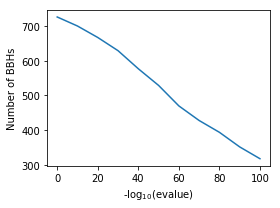

In [30]:
# BBH, try different evalues
evalues =  np.arange(0,110,10,dtype=float)
BBH_nums = list()
for evalue in evalues:
    BBH = extract_BBHs(10**(-evalue))
    BBH_nums.append(len(BBH))
plt.figure(figsize=(4,3))
plt.plot(evalues,BBH_nums)
plt.xlabel('-log$_{10}$(evalue)')
plt.ylabel('Number of BBHs')
plt.tight_layout()

In [31]:
BBHs = extract_BBHs(1e-20,True)

Number of homologs for query genes (evalue = 1e-20): 996
Number of homologs for target genes (evalue = 1e-20): 864
Number of BBHs (evalue = 1e-20): 667


In [32]:
# Build first template model
candidate_rxns = get_all_rxns_in_BBH(template_model, BBHs)

Number of candiate reactions: 1178


In [33]:
model_from_template = build_model_from_template(candidate_rxns,BBHs,True)

Number of reactions: 1178
Number of metabolits: 1188
Number of compartments: 3
Number of genes: 806
Number of missing genes: 140
Number of reactions with missing genes: 136


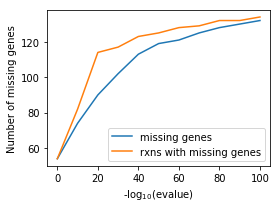

In [34]:
# test different evalues
evalues =  np.arange(0,110,10,dtype=float)
missing_genes = list()
rxns_with_missing_genes = list()
for evalue in evalues:
    model_from_template2 = update_missing_genes(model_from_template,10**(-evalue))
    missing_genes.append(len([gene for gene in model_from_template2.genes if 'missing' in gene.id]))
    rxns_with_missing_genes.append(len([rxn for rxn in model_from_template2.reactions if 'missing' in rxn.gene_reaction_rule]))
plt.figure(figsize=(4,3))
plt.plot(evalues,missing_genes,label='missing genes')
plt.plot(evalues,rxns_with_missing_genes,label='rxns with missing genes')
plt.xlabel('-log$_{10}$(evalue)')
plt.ylabel('Number of missing genes')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
model_from_template2 = update_missing_genes(model_from_template,1e-20,True)

Number of reactions: 1178
Number of metabolits: 1188
Number of compartments: 3
Number of genes: 769
Number of missing genes: 90
Number of reactions with missing genes: 114


In [36]:
k = 0
for rxn in model_from_template2.reactions:
    meta_id = rxn.annotation.get('biocyc')
    if meta_id is not None:
        k += 1
print('Number of reactions with MetaCyc id:',k,'/',len(model_from_template2.reactions))

Number of reactions with MetaCyc id: 532 / 1178


In [37]:
and_or_rxns = 0
rxns_with_missing_genes = 0
for rxn in model_from_template2.reactions:
    gr = rxn.gene_reaction_rule
    if ' and ' in gr and ' or ' in gr: 
        and_or_rxns += 1
    if '_missing' in gr: rxns_with_missing_genes += 1
        
print('and or rxns: {0}/{1}'.format(and_or_rxns,len(model_from_template2.reactions)))
print('reactions with missing genes: {0}/{1}'.format(rxns_with_missing_genes,len(model_from_template2.reactions)))

and or rxns: 23/1178
reactions with missing genes: 114/1178


In [38]:
# remove reactions with missing genes from the draft model
model_from_template3 = remove_rxns_with_missing_genes(model_from_template2)

Number of reactions: 1064
Number of metabolits: 1086
Number of compartments: 3
Number of genes: 613
Number of missing genes: 0
Number of reactions with missing genes: 0


In [39]:
cobra.io.save_json_model(model_from_template2,
                        '../../BuildDraftModelWithRaven2/Results/halo_iJ01366_template_with_missing_genes.json')
cobra.io.save_json_model(model_from_template3,
                        '../../BuildDraftModelWithRaven2/Results/halo_iJ01366_template_without_missing_genes.json')

## All models and templates we have now
* draft model reconstructed from MetaCyc by RAVEN
* draft model reconstructed from KEGG by RAVEN
* draft model reconstructed from template iJO1366 <br>

<br>Next step, we are going to merge the model from MetaCyc and iJO1366. We decided not using the draft model from KEGG due to following reasons:
* 1. MetaCyc contains experimentally elucidated pathways only;, while KEGG contains ortholog groups based annotations
* 2. The reactions from MetaCyc is charge balanced

In [40]:
halo_meta = '../../BuildDraftModelWithRaven2/Results/halo_metacycmodel_100.mat'
halo_kegg = '../../BuildDraftModelWithRaven2/Results/halo_keggmodel_50.mat'
halo_iJO = '../../BuildDraftModelWithRaven2/Results/halo_iJ01366_template_without_missing_genes.json'
ecoli_sbml = '../Dataset/iJO1366.xml'
ecoli_mat = '../Dataset/iJO1366.mat'

In [41]:
def load_metacyc_mat(model_file):
    # model_file: a mat file of the model. This model is the model that is reconstructed from MetaCyc with RAVEN.
    # return a dictionary, with filed name as key, field values as value
    # like data['id'] = 'metacycmodel'
    #
    
    ###### 
    # load mat model with cobrapy
    model = cobra.io.load_matlab_model(model_file)
    
    
    ###### 
    # load mnx of metabolites
    meta2mnx = dict()
    dfmnx = pd.read_csv('../Dataset/MNX2metacyc.tsv',index_col=1,sep='\t')

    for ind in dfmnx.index:meta2mnx[ind] = meta2mnx.get(ind,[]) + [dfmnx.loc[ind,'MNX']]
    
    
    ######
    # load annotation fields
    data = dict()
    
    mat = mat = loadmat(model_file)
    meta_vars = {"__globals__", "__header__", "__version__"}
    for item in mat.keys(): 
        if item not in meta_vars: model_id = item
    
    # field names
    names = mat[model_id].dtype.names
    
    # save data into a dictionary
    for i,item in enumerate(mat[model_id][0][0]):
        if names[i] in ['rxns','rxnNames','eccodes','rxnReferences','mets','metNames','metFormulas','inchis']:
            data[names[i]] = [i[0][0] if len(i[0])!=0 else '' for i in item]
        
        elif names[i] in ['subSystems']:
            lst = []
            for sub_item in item:
                try: lst.append([k[0] for k in sub_item[0][0]])
                except: lst.append([])
            data[names[i]] = lst
        elif names[i] in ['rxnMiriams','metMiriams']:
            lst = []
            for sub_item in item:
                anno = dict()
                try:
                    sub_item = sub_item[0][0][0]
                    for j in range(len(sub_item['name'])):
                        name = sub_item['name'][j][0][0]
                        value = sub_item['value'][j][0][0]
                        anno[name] = str(value)
                except:pass
                lst.append(anno)
            data[names[i]] = lst
        elif names[i] in ['rxnConfidenceScores','metCharges']:
            data[names[i]] = [k[0] for k in item]
        else: pass
    
    print('Loaded fields:',data.keys())
    
    ######
    # there are some metabolites formula cannot be correctly parsed by cobrapy. like ZN1 from RAVEN, which will
    # be treated as Z1N1. Most of such metabolites are ions
    for i,item in enumerate(data['metFormulas']):
        for element in ['ZN','MN','CU','MG','FE','CL','BR','AS','CA','CD','MO','TE','SE','NA']: 
            if element in item: item = item.replace(element,element.lower().title())
            data['metFormulas'][i] = item
    
    ######
    # assign annotation to the cobrapy model
    ## 1. assign rxn annotation and reaction subsystem
    
    for i in range(len(data['rxns'])):
        rxn_id = data['rxns'][i]
        anno = data['rxnMiriams'][i]
        
        # ec number
        ec = data['eccodes'][i]
        ec = ec.replace('ec-code/','')

        if len(ec) == 0: pass
        elif len(ec.split(';')) == 1: anno['ec-code'] = ec
        else: anno['ec-code'] = ec.split(';')
        
        # metacyc id
        anno['biocyc'] = 'META:'+rxn_id
        
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.annotation = anno
        
        # assign reaction subsystem
        subss = ''
        for item in data['subSystems'][i]: 
            subss += item +';'
        if subss.endswith(';'): subss = subss[:-1]
        rxn.subsystem = subss
    
    ## assign metabolites annotation
    for i in range(len(data['mets'])):
        met_id = data['mets'][i]
        anno = data['metMiriams'][i]
        
        # assign metacyc id
        anno['biocyc'] = 'META:'+met_id
        
        # assign mnx id
        mnx_id = meta2mnx.get(met_id)
        if mnx_id is not None: anno['metanetx.chemical'] = mnx_id
        
        met = model.metabolites.get_by_id(met_id)
        met.annotation = anno
        
        # assign charge
        met.charge = data['metCharges'][i]
        
        # assign formula
        met.formula = data['metFormulas'][i]

    return model

In [42]:
halo_meta = load_metacyc_mat(halo_meta)
halo_kegg = cobra.io.load_matlab_model(halo_kegg)
halo_iJO = cobra.io.load_json_model(halo_iJO)
eco = load_ecoli_model(ecoli_mat,ecoli_sbml)

Loaded fields: dict_keys(['rxns', 'rxnNames', 'eccodes', 'subSystems', 'rxnMiriams', 'rxnReferences', 'rxnConfidenceScores', 'mets', 'metNames', 'metFormulas', 'metCharges', 'inchis', 'metMiriams'])


for rxn in halo_iJO.reactions: print(rxn.annotation)

In [43]:
halo_meta.solver = 'gurobi'

In [44]:
def print_keggrxn(rxn):
    eq = rxn.reaction
    for met in rxn.metabolites:
        eq = eq.replace(met.id,met.name)
    print('KEGG:',eq)

In [45]:
def report_model_status(model):
    print('Number of reactions:',len(model.reactions))
    print('Number of metabolits:',len(model.metabolites))
    print('Number of compartments:',len(model.compartments))
    k = 0
    for gene in model.genes:
        if 'missing' in gene.id: k += 1
    print('Number of genes:',len(model.genes))
    print('Number of missing genes:',k)
    
    k = 0
    for rxn in model.reactions:
        if '_missing' in rxn.gene_reaction_rule: k += 1
    print('Number of reactions with missing genes:',k)

In [46]:
report_model_status(halo_meta)

Number of reactions: 1269
Number of metabolits: 1506
Number of compartments: 1
Number of genes: 1243
Number of missing genes: 0
Number of reactions with missing genes: 0


In [47]:
report_model_status(halo_iJO)

Number of reactions: 1064
Number of metabolits: 1086
Number of compartments: 3
Number of genes: 613
Number of missing genes: 0
Number of reactions with missing genes: 0


##  Check all metabolites ends with -GLU-N. Re-associate these metabolites to non-GLU-N format
We identified that some metabolites are in the form of -GLU-N(poly-glutamine). After carefully check the MetaCyc website and cross-referenced to KEGG database, N in those metabolites should be 0. Then we replaced those ones in -GLU-N format with non-GLU-N format.

In [48]:
# load all metacyc-kegg reaction pair
dfrxnpair = pd.read_csv('../Dataset/metacyc2keggrxns.tsv',sep='\t',index_col=0)
print(dfrxnpair.shape,dfrxnpair.columns)

(5747, 1) Index(['kegg'], dtype='object')


In [49]:
# load metacyc-kegg metabolites pairs
dfmetpair = pd.read_csv('../Dataset/metaCycMets_KEGG_pair.tsv',sep='\t',index_col=1)
print(dfmetpair.shape,dfmetpair.columns)

(5401, 1) Index(['metacyc'], dtype='object')


In [50]:
# For each of metabolites that endswith '-GLU-N', find one reaction that are from metacyc model 
# which has been associated with a kegg reaction
for met in halo_meta.metabolites:
    if met.id.upper().endswith('-GLU-N'): 
        print(met.id)
        for rxn in met.reactions:
            try: 
                kegg_id = dfrxnpair.loc[rxn.id,'kegg']
                kegg_rxn = halo_kegg.reactions.get_by_id(kegg_id)
                break
            except: continue
        print(rxn.reaction)
        print_keggrxn(kegg_rxn)
        print(kegg_rxn.reaction)
        print('')

5-10-METHENYL-THF-GLU-N
METHYLENE-THF-GLU-N + NADP <=> 5-10-METHENYL-THF-GLU-N + NADPH
KEGG: NADP+ + 5,10-Methylenetetrahydrofolate <=> NADPH + 5,10-Methenyltetrahydrofolate
C00006 + C00143 <=> C00005 + C00445

5-METHYL-THF-GLU-N
5-METHYL-THF-GLU-N + HOMO-CYS --> MET + THF-GLU-N
KEGG: L-Homocysteine + 5-Methyltetrahydrofolate <=> L-Methionine + Tetrahydrofolate
C00155 + C00440 <=> C00073 + C00101

DIHYDROFOLATE-GLU-N
DIHYDROFOLATE-GLU-N + NADPH + PROTON --> NADP + THF-GLU-N
KEGG: NADP+ + Tetrahydrofolate <=> NADPH + H+ + Dihydrofolate
C00006 + C00101 <=> C00005 + C00080 + C00415

FORMYL-THF-GLU-N
5-10-METHENYL-THF-GLU-N + WATER <=> FORMYL-THF-GLU-N + PROTON
KEGG: H2O + 5,10-Methenyltetrahydrofolate <=> H+ + 10-Formyltetrahydrofolate
C00001 + C00445 <=> C00080 + C00234

METHYLENE-THF-GLU-N
AMINOMETHYLDIHYDROLIPOYL-GCVH + THF-GLU-N <=> AMMONIUM + DIHYDROLIPOYL-GCVH + METHYLENE-THF-GLU-N
KEGG: Tetrahydrofolate + S-Aminomethyldihydrolipoylprotein <=> Ammonia + 5,10-Methylenetetrahydrofolat

In [51]:
# Manually check above reactions, associate each of '*-GLU-N' metabolites to a kegg id 
# based on metacyc-kegg reaction pairs
GluNs = {
    '5-10-METHENYL-THF-GLU-N': 'C00445',
    '5-METHYL-THF-GLU-N': 'C00440',
    'DIHYDROFOLATE-GLU-N':'C00415',
    'FORMYL-THF-GLU-N':'C00234',
    'METHYLENE-THF-GLU-N': 'C00143',
    'N5-Formyl-THF-Glu-N':'C03479',
    'THF-GLU-N': 'C00101'
}

In [52]:
# Reassociate those GLU-N to non-GLU metabolites in metacyc
for metg,kegg_id in GluNs.items():
    print(metg,kegg_id,dfmetpair.loc[kegg_id,'metacyc'])

5-10-METHENYL-THF-GLU-N C00445 5-10-METHENYL-THF
5-METHYL-THF-GLU-N C00440 5-METHYL-THF
DIHYDROFOLATE-GLU-N C00415 DIHYDROFOLATE
FORMYL-THF-GLU-N C00234 10-FORMYL-THF
METHYLENE-THF-GLU-N C00143 METHYLENE-THF
N5-Formyl-THF-Glu-N C03479 5-FORMYL-THF
THF-GLU-N C00101 THF


In [53]:
def update_rxn(model,old_met_id,new_met_id):
    old_met = model.metabolites.get_by_id(old_met_id)
    for old_rxn in old_met.reactions:
        
        # create a new reaction with replaced metabolite
        new_rxn = cobra.Reaction(old_rxn.id)
        new_rxn.name = old_rxn.name
        new_rxn.subsystem = old_rxn.subsystem
        new_rxn.lower_bound = old_rxn.lower_bound
        new_rxn.upper_bound = old_rxn.upper_bound
        
        new_met = cobra.Metabolite(new_met_id,name=new_met_id,compartment=old_met.compartment)
        
        coeffs = dict()
        for met in old_rxn.metabolites:
            if met.id == old_met.id: coeffs[new_met] = old_rxn.get_coefficient(met)
            else: coeffs[met] = old_rxn.get_coefficient(met)
        new_rxn.add_metabolites(coeffs)
        new_rxn.gene_reaction_rule = old_rxn.gene_reaction_rule 
        
        # remove old reactions and add new reaction
        model.remove_reactions([old_rxn])
        model.add_reaction(new_rxn)
    
    # findally, remove old metabolites
    model.remove_metabolites([old_met])
    return model

In [54]:
## Replace the all metabolites that endswith -GLU-N with non-GLU-N format
for met in halo_meta.metabolites:
    if met.id.upper().endswith('-GLU-N'):
        kegg_id = GluNs[met.id]
        new_id = dfmetpair.loc[kegg_id,'metacyc']
        halo_meta = update_rxn(halo_meta,met.id,new_id)

In [55]:
# print all changed reactions to have a final manual check
for metg,kegg_id in GluNs.items():
    new_id = dfmetpair.loc[kegg_id,'metacyc']
    met = halo_meta.metabolites.get_by_id(new_id)
    for rxn in met.reactions: print(rxn.reaction)

5-10-METHENYL-THF + WATER <=> 10-FORMYL-THF + PROTON
5-FORMYL-THF + ATP --> 5-10-METHENYL-THF + ADP + Pi
5-10-METHENYL-THF + WATER --> 5-FORMYL-THF + PROTON
METHYLENE-THF + NADP <=> 5-10-METHENYL-THF + NADPH
SS-DIMETHYL-BETA-PROPIOTHETIN + THF --> 5-METHYL-THF + CPD-7672 + PROTON
METHYLENE-THF + NADH + PROTON --> 5-METHYL-THF + NAD
5-METHYL-THF + HOMO-CYS --> MET + THF
DUMP + METHYLENE-THF --> DIHYDROFOLATE + TMP
DIHYDROFOLATE + NADPH + PROTON --> NADP + THF
7-8-DIHYDROPTEROATE + ATP + GLT --> ADP + DIHYDROFOLATE + PROTON + Pi
Acceptor + GLY + GTP + METHYLENE-THF + WATER + tRNA-uridine34 --> DIHYDROFOLATE + Donor-H2 + GDP + 2.0 PROTON + Pi + tRNA-containing-5-CarbMeAminome-uridine
Acceptor + GLY + GTP + METHYLENE-THF + WATER + tRNA-2-thiouridine34 --> DIHYDROFOLATE + Donor-H2 + GDP + 2.0 PROTON + Pi + tRNA-containing-5-CarbMeAminome-2-ThioU
5-10-METHENYL-THF + WATER <=> 10-FORMYL-THF + PROTON
10-FORMYL-THF + L-methionyl-tRNAfmet --> N-formyl-L-methionyl-tRNAfmet + PROTON + THF
10-FORMY

## Manually curate metabolites ids
Since some metabolites have multiple metacyc ids. In the case that one metabolites has more than one metacyc id existing in the model, remove one of them

In [56]:
# 'HS' and 'CPD-7046' are both in the halo_meta model. 
# They represent the same metabolit with mnx id: 'MNXM89582'
# Replace 'CPD-7046' by 'HS'
rxns = list()
old_met = halo_meta.metabolites.get_by_id('CPD-7046' )
for rxn in old_met.reactions:
    rxn1 = rxn.copy()
    rxn1.subtract_metabolites(rxn1.metabolites)
    coeffs = dict()
    for met in rxn.metabolites:
        coeff = rxn.get_coefficient(met)
        if met.id == 'CPD-7046':
            met = halo_meta.metabolites.get_by_id('HS')
        coeffs[met] = coeff
    
    rxn1.add_metabolites(coeffs)
    print(rxn1.reaction)
    rxns.append(rxn1)
halo_meta.remove_reactions(old_met.reactions)
halo_meta.add_reactions(rxns)
halo_meta.repair()

Fe4S4-Cluster-Protein + Octanoylated-domains + 6.0 PROTON + 2.0 Reduced-ferredoxins + 2.0 S-ADENOSYLMETHIONINE --> 2.0 CH33ADO + Dihydro-Lipoyl-Proteins + 4.0 FE+2 + 2.0 HS + Iron-Sulfur-Cluster-Scaffold-Proteins + 2.0 MET + 2.0 Oxidized-ferredoxins


## Find all transport reactions in metacyc model. Save all these reactions into a new model. Remove those reactions from metacyc model
Sincd there is no compartment information in the reaction, the metabolites transported are missing in the reaction because they exit in both side of the reaction. We will manually check the metacyc website for those transporters and then add them back

In [57]:
# check transport reaction in halo_meta
# load transport reaction ids in metacyc database
# The transport reactions were identified based on the transport reaction ids from RAVEN.
is_transport = dict()
for item in open('../Dataset/metaCyc_transport_rxns.txt').read().split(): is_transport[item] = True
fhand = open('../Results/transport_rxns.tsv','w')
transmodel = cobra.Model('transmodel')
non_trans_rxns = list()
trans_rxns = list()
k = 0
for rxn in halo_meta.reactions:
    if is_transport.get(rxn.id,False): 
        k += 1
        print(k,rxn.id,rxn.name,':',rxn.reaction)
        fhand.write('{0}\t{1}\t{2}\t{3}\n'.format(k,rxn.id,rxn.name,rxn.reaction))
        trans_rxns.append(rxn)
    else: non_trans_rxns.append(rxn)
transmodel.add_reactions(trans_rxns)
halo_meta.remove_reactions(trans_rxns)
cobra.io.write_sbml_model(transmodel,'../Results/transport_rxns.xml')
fhand.close()

halo_meta = cobra.Model(halo_meta.id)
halo_meta.add_reactions(non_trans_rxns)

1 RXN0-21 glutathione exporter : ATP + WATER --> ADP + PROTON + Pi
2 RXN-9615 ammonium transporter :  --> 
3 TRANS-RXN0-479 selenite ABC transporter;selenite  ABC transporter : ATP + WATER --> ADP + PROTON + Pi
4 ABC-70-RXN sulfate  ABC transporter;sulfate ABC transporter : ATP + WATER --> ADP + PROTON + Pi
5 ABC-27-RXN transport of phosphate : ATP + WATER --> ADP + PROTON + Pi
6 TRANS-RXN0-286 lipid II flippase :  --> 
7 TRANS-RXN0-268 Transport of L-Ala-D-Glu-meso-A2pm : ATP + WATER --> ADP + PROTON + Pi
8 TRANS-RXN-355 n-hexane efflux pump :  --> 
9 RXN0-11 transport of glutathione : ATP + WATER --> ADP + PROTON + Pi
10 TRANS-RXN-167 N-acetyl-D-galactosamine PTS;N-acetylglucosamine PTS permease;N-acetyl-D-glucosamine PTS permease : Hpr-pi-phospho-L-histidines + N-acetyl-D-glucosamine --> Hpr-Histidine + N-ACETYL-D-GLUCOSAMINE-6-P
11 ABC-24-RXN putrescine/spermidine ABC transporter : ATP + WATER --> ADP + PROTON + Pi
12 TRANS-RXN-352 deoxycholate efflux pump :  --> 
13 TRANS-RXN-296 

### Add _c for all metabolite identifiers. Change the compartment to 'c'

In [58]:
halo_meta.repair()
for met in halo_meta.metabolites:
    met.id = met.id+'_c'
    met.compartment = 'c'
halo_meta.repair()

### Add transport reactions back manully

In [59]:
transmodel = cobra.io.read_sbml_model('../Results/transport_rxns.xml')
report_model_status(transmodel)

Number of reactions: 132
Number of metabolits: 20
Number of compartments: 1
Number of genes: 236
Number of missing genes: 0
Number of reactions with missing genes: 0


In [60]:
def format_transported_met(rxn_id,transmodel,metacyc_model,direction,met_ids,weights):
    # rxn_id: rxn_id in transmodel
    # transmodel: the model containing all transport reactions
    # metacyc model: model reconstructed from MetaCyc
    # direction: 'in' or 'out'. 'in': e to c, out: c to e
    # met_ids: transported metabolite ids
    # weights: coeffs of tranported metabolite
    # 
    # Assume all metbolites in transport reactions before adding transported metabolit as in cyctosal.
    # 
    rxn = transmodel.reactions.get_by_id(rxn_id)
    new_rxn = rxn.copy()
    
    # 1. add _c to exsiting metaboites in transport reaction
    coeffs = dict()
    for met in rxn.metabolites:
        new_id = met.id+'_c'
        try: new_met = metacyc_model.metabolites.get(new_id)
        except: 
            new_met = met.copy()
            new_met.id = new_met.id +'_c'
            new_met.compartment = 'c'
        coeffs[new_met] = rxn.get_coefficient(met)
    
    # 2. add transported metaboites
    def get_met_ec(met_id):
        try: met_e = metacyc_model.metabolites.get_by_id(met_id+'_e')
        except: 
            met_e = cobra.Metabolite(met_id+'_e')
            met_e.annotation = {'biocyc':'META:'+met_id}
            #met_e.name = met_id
            met_e.compartment = 'e'
            
    
        try: met_c = metacyc_model.metabolites.get_by_id(met_id+'_c')
        except: 
            met_c = cobra.Metabolite(met_id+'_c')
            #met_c.name = met_id
            met_e.annotation = {'biocyc':'META:'+met_id}
            met_c.compartment = 'c'
    
        return met_e,met_c
    
    for i in range(len(met_ids)):
        met_id = met_ids[i]
        number_of_molecular = weights[i]
        met_e,met_c = get_met_ec(met_id)
        if direction == 'in': 
            coeffs[met_e] = -number_of_molecular
            coeffs[met_c] = number_of_molecular
        elif direction == 'out':
            coeffs[met_c] = -number_of_molecular
            coeffs[met_e] = number_of_molecular
        else: print('Error: check direction. ')
    new_rxn = rxn.copy()
    new_rxn.subtract_metabolites(new_rxn.metabolites)
    new_rxn.add_metabolites(coeffs)
    print(rxn.id,new_rxn.reaction)
    return new_rxn

In [61]:
report_model_status(halo_meta)

Number of reactions: 1137
Number of metabolits: 1446
Number of compartments: 1
Number of genes: 1007
Number of missing genes: 0
Number of reactions with missing genes: 0


In [62]:
trans_rxns_formated = list()
for line in open('../Results/transport_rxns_mannual.tsv'):
    cont = line.strip().split('\t')
    rxn_id = cont[1]
    direction = cont[5]
    met_ids = cont[4].split(',')
    weights = [int(item) for item in cont[6].split(',')]
        
    trans_rxns_formated.append(format_transported_met(rxn_id,transmodel,halo_meta,direction,
                                                  met_ids,weights)) 

RXN0-21 ATP_c + GLUTATHIONE_c + WATER_c --> ADP_c + GLUTATHIONE_e + PROTON_c + Pi_c
RXN-9615 AMMONIUM_e --> AMMONIUM_c
TRANS-RXN0-479 ATP_c + SELENITE_e + WATER_c --> ADP_c + PROTON_c + Pi_c + SELENITE_c
ABC-70-RXN ATP_c + SULFATE_e + WATER_c --> ADP_c + PROTON_c + Pi_c + SULFATE_c
ABC-27-RXN ATP_c + Pi_e + WATER_c --> ADP_c + PROTON_c + Pi_c + Pi_c
TRANS-RXN0-286 C6_c --> C6_e
TRANS-RXN0-268 ATP_c + L-ALA-GAMMA-D-GLU-DAP_e + WATER_c --> ADP_c + L-ALA-GAMMA-D-GLU-DAP_c + PROTON_c + Pi_c
TRANS-RXN-355 CPD-9288_c --> CPD-9288_e
RXN0-11 ATP_c + GLUTATHIONE_e + WATER_c --> ADP_c + GLUTATHIONE_c + PROTON_c + Pi_c
TRANS-RXN-167 Hpr-pi-phospho-L-histidines_c + N-acetyl-D-glucosamine_c + N-acetyl-D-glucosamine_e --> Hpr-Histidine_c + N-ACETYL-D-GLUCOSAMINE-6-P_c + N-acetyl-D-glucosamine_c
ABC-24-RXN ATP_c + SPERMIDINE_e + WATER_c --> ADP_c + PROTON_c + Pi_c + SPERMIDINE_c
TRANS-RXN-352 DEOXYCHOLATE_c --> DEOXYCHOLATE_e
TRANS-RXN-296 ATP_c + COBINAMIDE_e + WATER_c --> ADP_c + COBINAMIDE_c + PRO

In [63]:
halo_meta.add_reactions(trans_rxns_formated)
halo_meta.repair()
report_model_status(halo_meta)

Number of reactions: 1269
Number of metabolits: 1627
Number of compartments: 2
Number of genes: 1243
Number of missing genes: 0
Number of reactions with missing genes: 0


In [64]:
print(halo_meta.compartments)

{'c': '', 'e': ''}


### Add annotation field to rxn and met in metacyc model. Add 'biocyc' to both

for rxn in halo_meta.reactions:
    rxn.annotation['biocyc'] = rxn.id
    print(rxn.id,rxn.annotation)

for met in halo_meta.metabolites:
    met.annotation['biocyc'] = met.id.replace('_c','').replace('_e','')
    print(met.id,met.annotation)

## Combine draft models based on metacyc and iJO1366
* For template model on iJO1366
    * replace _p with _c
    * use metacyc id for metabolites and reactions if available
    * if multiple metacyc ids exist, use the one in halomodel if available
    * ignore transport reaction between c and e 
* Add reactions from metacyc into above model

In [65]:
def create_universal_met(eco_met,halomodel,universal,mnx2meta):
    is_in_halo = dict()
    for met in halomodel.metabolites: is_in_halo[met.id] = True
    mnx_id = eco_met.annotation.get('metanetx.chemical')
    
    comp = eco_met.compartment
    if comp == 'p': comp = 'c'
    met_id = None
    
    if mnx_id is None or mnx2meta.get(mnx_id,None) is None: 
        # if there is no mnx id or no metacyc id, use bigg id instead
        met_id = eco_met.annotation['bigg.metabolite'] + '_' + comp
    else:
        meta_ids = mnx2meta[mnx_id]
        for item in meta_ids:
            if is_in_halo.get(item+ '_' + comp,False): 
                met_id = item+ '_' + comp
                break
        if met_id is None: met_id = meta_ids[0] + '_' + comp
    try: 
        new_met = halomodel.metabolites.get_by_id(met_id)
    except:
        try:
            new_met = universal.metabolites.get_by_id(met_id)
        except:
            new_met = eco_met.copy()
            new_met.id = met_id
            new_met.compartment = comp
    return new_met

In [66]:
def update_rxnid(new_rxn,halomodel,universal):
    # metacyc reaction ids in halomodel:
    halo_rxn_ids = dict()
    halo_rxn_mets = dict()
    mets_rxn = dict()
    for rxn in halomodel.reactions: 
        halo_rxn_ids[rxn.id] = True
        mets = [met.id for met in rxn.metabolites]
        mets.sort()
        mets = tuple(mets)
        halo_rxn_mets[mets] = True
        mets_rxn[mets] = rxn
        
    # 1. check metacyc id
    meta_ids = new_rxn.annotation.get('biocyc')
    new_rxn_id = new_rxn.id
    # case 1: there is metacyc ids, map metacyc id
    if meta_ids is not None:
        if type(meta_ids) == str: meta_ids = [meta_ids]
        for meta_id in meta_ids:
            meta_id = meta_id.replace('META:','')
            if halo_rxn_ids.get(meta_id,False): new_rxn_id = meta_id
    
    # case 2: if case 1 failed, check reaction equations
    else:
        new_mets = [met.id for met in new_rxn.metabolites]
        new_mets.sort()
        new_mets = tuple(new_mets)
        if halo_rxn_mets.get(new_mets,False): 
            # the two reactions contain the same metabolites. Now compare the equations, including direction
            eq1 = new_rxn.reaction
            eq2 = mets_rxn[new_mets].reaction
            eq1 = eq1.split()
            eq2 = eq2.split()
            
            eq1.sort()
            eq2.sort()
            if eq1 == eq2:
                # print(new_rxn.id,new_rxn.reaction)
                # print(mets_rxn[new_mets].id,mets_rxn[new_mets].reaction)
                # print('')
                new_rxn_id = mets_rxn[new_mets].id
            
    new_rxn.id = new_rxn_id
    
    # if new_rxn_id is in universal model, use the reactions in univeral model
    try: 
        rxn_universal = universal.reactions.get_by_id(new_rxn_id)
        gr_rule = new_rxn.gene_reaction_rule 
        new_rxn = rxn_universal.copy()
        new_rxn.gene_reaction_rule = gr_rule
    except: None
    
    
    return new_rxn

In [67]:
def create_universal_rxn(eco_rxn,halomodel,universal,mnx2meta):
    coeffs = dict()
    is_transport = False
    
    # convert metabolite ids
    mets = list()
    for eco_met in eco_rxn.metabolites:
        new_met = create_universal_met(eco_met,halomodel,universal,mnx2meta)
        if new_met.id in mets:
            is_transport = True

        mets.append(new_met.id)
        coeffs[new_met] = coeffs.get(new_met,0) + eco_rxn.get_coefficient(eco_met)

    if is_transport and 'BIOMASS' not in eco_rxn.id: return None
    else:
        # convert reaction ids
        new_rxn = eco_rxn.copy()
        new_rxn.subtract_metabolites(new_rxn.metabolites)
        new_rxn.add_metabolites(coeffs)
        
        new_rxn = update_rxnid(new_rxn,halomodel,universal)
        return new_rxn

In [68]:
def remove_transport_rxn_from_model_on_template(model):
    rxns = list()
    
    for rxn in model.reactions:
        is_transport = False
        mets = dict()
        for met in rxn.metabolites: 
            comp = met.compartment
            met_id = met.id.replace('_{0}'.format(comp),'')
            if mets.get(met_id) is not None: is_transport = True
            else: mets[met_id] = 0

        if not is_transport: rxns.append(rxn)
    
    new_model = cobra.Model('model_from_template_without_transport')
    new_model.add_reactions(rxns)
    print('{0} transport reactions were removed'.format(len(model.reactions)-len(rxns)))
    return new_model

In [69]:
# break point
# print(gang)

#### 1. covert iJO1366 to a universal model
* replace _p with _c
* use metacyc id for metabolites and reactions if available
* if multiple metacyc ids exist, use the one in halomodel if available
* ignore transport reaction between c and e

In [70]:
universal = cobra.Model('univeral')
mnx2meta = dict()
for line in open('../Dataset/MNX2metacyc.tsv'):
    cont = line.split()
    mnx2meta[cont[0]] = mnx2meta.get(cont[0],[]) + [cont[1]]

univeral_rxns = dict()
for eco_rxn in eco.reactions:
    new_rxn = create_universal_rxn(eco_rxn,halo_meta,universal,mnx2meta)
    if new_rxn is None: continue
    
    univeral_rxns[new_rxn.id] = new_rxn
universal.add_reactions(univeral_rxns.values())

In [71]:
report_model_status(universal)

Number of reactions: 2131
Number of metabolits: 1454
Number of compartments: 2
Number of genes: 1002
Number of missing genes: 0
Number of reactions with missing genes: 0


def block_amino_acid_update_eco(model):
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c']
    for met_id in amino_acids: 
        met = model.metabolites.get_by_id(met_id)
        for rxn in met.reactions:
            if 'BIOMASS' in rxn.name: continue
            if rxn.id.endswith('tex'):
                rxn.upper_bound = 0
                print(rxn.id,rxn.reaction)
    return model

In [72]:
universal.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'
eco.objective = 'BIOMASS_Ec_iJO1366_core_53p95M'

# check why? make sure growth rate is higher after removal of compartment p. 
print(universal.optimize())
print(eco.optimize())

<Solution 0.446 at 0x132b1b2ba8>
<Solution 0.982 at 0x132b1b2ba8>


#### 2. convert  the draft model based template to a small universal model. Remove all transport reactions

In [73]:
# change the ids in model halo_iJO with metacyc ids.
halo_iJO_meta = cobra.Model('halo_iJO1366_metacycids')
template_rxns = dict()

for rxn in halo_iJO.reactions:
    new_rxn = create_universal_rxn(rxn,halo_meta,universal,mnx2meta)
    if new_rxn is None: continue
    template_rxns[new_rxn.id] = new_rxn
halo_iJO_meta.add_reactions(template_rxns.values())
halo_iJO_meta = remove_transport_rxn_from_model_on_template(halo_iJO_meta)

7 transport reactions were removed


In [74]:
report_model_status(halo_iJO)

Number of reactions: 1064
Number of metabolits: 1086
Number of compartments: 3
Number of genes: 613
Number of missing genes: 0
Number of reactions with missing genes: 0


In [75]:
report_model_status(halo_iJO_meta)

Number of reactions: 887
Number of metabolits: 831
Number of compartments: 1
Number of genes: 507
Number of missing genes: 0
Number of reactions with missing genes: 0


#### 3. compare draft models from template and metacyc

In [76]:
k = 1
meta_model_ids = [rxn.id for rxn in halo_meta.reactions]
for rxn in halo_iJO_meta.reactions:
    if rxn.id in meta_model_ids:
        rxn1 = halo_meta.reactions.get_by_id(rxn.id)
        print(k,rxn.id,rxn.reaction)
        print(k,rxn1.id,rxn1.reaction)
        print('')
        k += 1

1 4.2.1.59-RXN 3-Hydroxy-octanoyl-ACPs_c --> 2-Octenoyl-ACPs_c + WATER_c
1 4.2.1.59-RXN 3-Hydroxy-octanoyl-ACPs_c --> 2-Octenoyl-ACPs_c + WATER_c

2 RXN-9537 R-3-hydroxymyristoyl-ACPs_c --> Tetradec-2-enoyl-ACPs_c + WATER_c
2 RXN-9537 R-3-hydroxymyristoyl-ACPs_c --> Tetradec-2-enoyl-ACPs_c + WATER_c

3 RXN-11477 3-Hydroxyglutaryl-ACP-methyl-ester_c --> Enoylglutaryl-ACP-methyl-esters_c + WATER_c
3 RXN-11477 3-Hydroxyglutaryl-ACP-methyl-ester_c --> Enoylglutaryl-ACP-methyl-esters_c + WATER_c

4 RXN-11481 3-hydroxypimeloyl-ACP-methyl-esters_c --> Enoylpimeloyl-ACP-methyl-esters_c + WATER_c
4 RXN-11481 3-hydroxypimeloyl-ACP-methyl-esters_c --> Enoylpimeloyl-ACP-methyl-esters_c + WATER_c

5 MALONYL-ACPDECARBOX-RXN MALONYL-ACP_c + PROTON_c --> ACETYL-ACP_c + CARBON-DIOXIDE_c
5 MALONYL-ACPDECARBOX-RXN MALONYL-ACP_c + PROTON_c --> ACETYL-ACP_c + CARBON-DIOXIDE_c

6 3-OXOACYL-ACP-SYNTH-BASE-RXN ACETYL-ACP_c + MALONYL-ACP_c + PROTON_c --> ACP_c + Acetoacetyl-ACPs_c + CARBON-DIOXIDE_c
6 3-OXOACY

265 3-OCTAPRENYL-4-OHBENZOATE-DECARBOX-RXN 3-OCTAPRENYL-4-HYDROXYBENZOATE_c + PROTON_c --> 2-OCTAPRENYLPHENOL_c + CARBON-DIOXIDE_c

266 OROPRIBTRANS-RXN OROTIDINE-5-PHOSPHATE_c + PPI_c <=> OROTATE_c + PRPP_c
266 OROPRIBTRANS-RXN OROTIDINE-5-PHOSPHATE_c + PPI_c <=> OROTATE_c + PRPP_c

267 RXN-10819 ATP_c + CO-A_c + PHENYLACETATE_c --> AMP_c + CPD-207_c + PPI_c
267 RXN-10819 ATP_c + CO-A_c + PHENYLACETATE_c --> AMP_c + CPD-207_c + PPI_c

268 PANTOATE-BETA-ALANINE-LIG-RXN ATP_c + B-ALANINE_c + L-PANTOATE_c --> AMP_c + PANTOTHENATE_c + PPI_c + PROTON_c
268 PANTOATE-BETA-ALANINE-LIG-RXN ATP_c + B-ALANINE_c + L-PANTOATE_c --> AMP_c + PANTOTHENATE_c + PPI_c + PROTON_c

269 RXN0-5038 CAMP_c + WATER_c --> AMP_c + PROTON_c
269 RXN0-5038 CAMP_c + WATER_c --> AMP_c + PROTON_c

270 PNPOXI-RXN OXYGEN-MOLECULE_c + PYRIDOXINE-5P_c --> HYDROGEN-PEROXIDE_c + PYRIDOXAL_PHOSPHATE_c
270 PNPOXI-RXN OXYGEN-MOLECULE_c + PYRIDOXINE-5P_c --> HYDROGEN-PEROXIDE_c + PYRIDOXAL_PHOSPHATE_c

271 PMPOXI-RXN OXYGEN-MOL

324 DTDPGLUCDEHYDRAT-RXN DTDP-D-GLUCOSE_c --> DTDP-DEOH-DEOXY-GLUCOSE_c + WATER_c
324 DTDPGLUCDEHYDRAT-RXN DTDP-D-GLUCOSE_c --> DTDP-DEOH-DEOXY-GLUCOSE_c + WATER_c

325 TETRAACYLDISACC4KIN-RXN ATP_c + BISOHMYR-GLC_c --> ADP_c + LIPID-IV-A_c + PROTON_c
325 TETRAACYLDISACC4KIN-RXN ATP_c + BISOHMYR-GLC_c --> ADP_c + LIPID-IV-A_c + PROTON_c

326 THREDEHYD-RXN THR_c --> 2-OXOBUTANOATE_c + AMMONIUM_c
326 THREDEHYD-RXN THR_c --> 2-OXOBUTANOATE_c + AMMONIUM_c

327 2TRANSKETO-RXN ERYTHROSE-4P_c + XYLULOSE-5-PHOSPHATE_c <=> FRUCTOSE-6P_c + GAP_c
327 2TRANSKETO-RXN ERYTHROSE-4P_c + XYLULOSE-5-PHOSPHATE_c <=> FRUCTOSE-6P_c + GAP_c

328 THYMIDYLATESYN-RXN DUMP_c + METHYLENE-THF_c --> DIHYDROFOLATE_c + TMP_c
328 THYMIDYLATESYN-RXN DUMP_c + METHYLENE-THF_c --> DIHYDROFOLATE_c + TMP_c

329 THI-P-KIN-RXN ATP_c + THIAMINE-P_c --> ADP_c + THIAMINE-PYROPHOSPHATE_c
329 THI-P-KIN-RXN ATP_c + THIAMINE-P_c --> ADP_c + THIAMINE-PYROPHOSPHATE_c

330 TRIOSEPISOMERIZATION-RXN DIHYDROXY-ACETONE-PHOSPHATE_c <=> GAP

#### 4. Combine two draft models

In [85]:
def is_subset(lst1,lst2):
    # check if elements in lst1 are all in lst2
    is_ = True
    for item in lst1:
        if item not in lst2: is_ = False
    return is_

In [91]:
# add reactions in metacyc draft model to halo_iJO_meta model
combined_rxns = dict()
for rxn in halo_iJO_meta.reactions: combined_rxns[rxn.id] = rxn
for rxn in halo_meta.reactions:
    eco_rxn = combined_rxns.get(rxn.id)
    if eco_rxn is None: combined_rxns[rxn.id] = rxn
    else: 
        # if the rxn exist in both models, combine their gr rule 
        gr_eco = eco_rxn.gene_reaction_rule
        gr_meta = rxn.gene_reaction_rule
        if gr_eco == gr_meta: continue
            
        ## case 1: if 'and' not in both gr rules. Combine all genes with 'or'
        if ' and ' not in gr_eco and ' and ' not in gr_meta:
            genes = set(parse_gr(gr_eco)+parse_gr(gr_meta))
            new_gr = ''
            for gene in genes: new_gr += gene + ' or '
            new_gr = new_gr[:-4]
            
            eco_rxn.gene_reaction_rule = new_gr
        
        ## case 2: if two grs only differ in 'and' 'or' while with the same genes. use the one from eco li
        elif parse_gr(gr_eco) == parse_gr(gr_meta): pass
        
        ## case 3: if genes in metacyc model is a subset of eco model, use the one from eco model
        elif is_subset(parse_gr(gr_meta),parse_gr(gr_eco)): pass
        else: 
            print(gr_eco)
            print(gr_meta)
            #print(new_gr)
            print('')
print('For above reactions, use the one from ecoli at the moment.')
            


halo_meta_c = cobra.Model('combined_metacyc_iJO1366')
halo_meta_c.add_reactions(combined_rxns.values())

g0783 and g0784
g0784 or g3636

g0783 and g0784
g0783 or g3637

g0266 and g3202
g0266 or g0267 or g3201 or g3202

g1283 and g1284
g1283 or g1284 or g1379

g1283 and g1284
g1283 or g1284 or g1379

g2209 and g3925
g2208 or g2209

g3104 and g3222
g0617 or g3104 or g3662

g2282 and g2283
g1968 or g2282 or g2283

g2686 and g2687
g2685 or g2686 or g2687

g0783 and g0784
g3636 or g3637

For above reactions, use the one from ecoli at the moment.


In [92]:
report_model_status(halo_meta)

Number of reactions: 1269
Number of metabolits: 1627
Number of compartments: 2
Number of genes: 1243
Number of missing genes: 0
Number of reactions with missing genes: 0


In [93]:
report_model_status(halo_meta_c)

Number of reactions: 1807
Number of metabolits: 1952
Number of compartments: 2
Number of genes: 1282
Number of missing genes: 0
Number of reactions with missing genes: 0


#### 4.6 compare the combinded model and the universal model

In [94]:
# there are some reactions with the same id while with different equations
# 
k = 1
meta_model_ids = [rxn.id for rxn in halo_meta_c.reactions]
for rxn in universal.reactions:
    if rxn.id in meta_model_ids:
        rxn1 = halo_meta_c.reactions.get_by_id(rxn.id)
        if rxn.reaction != rxn1.reaction:
            print(k,rxn.id,rxn.reaction)
            print(k,rxn1.id,rxn1.reaction)
            print('')
            k += 1

1 TRANS-RXN0-281 3-KETOBUTYRATE_e <=> 3-KETOBUTYRATE_c
1 TRANS-RXN0-281 3-KETOBUTYRATE_e --> 3-KETOBUTYRATE_c

2 ACETYLGLUTKIN-RXN ACETYL-GLU_c + ATP_c --> ADP_c + N-ACETYL-GLUTAMYL-P_c
2 ACETYLGLUTKIN-RXN ACETYL-GLU_c + ATP_c <=> ADP_c + N-ACETYL-GLUTAMYL-P_c

3 RXN0-1923 ACETYLSERINE_e <=> ACETYLSERINE_c
3 RXN0-1923 ACETYLSERINE_c --> ACETYLSERINE_e

4 RXN0-1981 ACET_e <=> ACET_c
4 RXN0-1981 ACET_e + NA+_e <=> ACET_c + NA+_c

5 ASPARTATEKIN-RXN ATP_c + L-ASPARTATE_c <=> ADP_c + L-BETA-ASPARTYL-P_c
5 ASPARTATEKIN-RXN ATP_c + L-ASPARTATE_c --> ADP_c + L-BETA-ASPARTYL-P_c

6 TRANS-RXN0-240 BIOTIN_e <=> BIOTIN_c
6 TRANS-RXN0-240 BIOTIN_e --> BIOTIN_c

7 TRANS-RXN0-445 CHITOBIOSE_e <=> CHITOBIOSE_c
7 TRANS-RXN0-445 CHITOBIOSE_e --> CHITOBIOSE_c

8 THIOSULFATE-SULFURTRANSFERASE-RXN HCN_c + S2O3_c --> HSCN_c + PROTON_c + SO3_c
8 THIOSULFATE-SULFURTRANSFERASE-RXN HCN_c + S2O3_c --> HSCN_c + 2.0 PROTON_c + SO3_c

9 RXN0-1924 CYS_e <=> CYS_c
9 RXN0-1924 CYS_c --> CYS_e

10 3-DEHYDROQUINATE-DEH

In [95]:
# there are some reactions with the same id while with different equations
# 
k = 1
meta_model_ids = [rxn.id for rxn in halo_iJO_meta.reactions]
for rxn in universal.reactions:
    if rxn.id in meta_model_ids:
        rxn1 = halo_meta_c.reactions.get_by_id(rxn.id)
        if rxn.reaction != rxn1.reaction:
            print(k,rxn.id,rxn.reaction)
            print(k,rxn1.id,rxn1.reaction)
            print('')
            k += 1

## Add exchange reactions for all metabolites in medium. Use _e for extracellular compartment. Set all these exchange reversible

* For those metabolites that doesn't have any transporters, add reversible transport reactions
* use metacyc id for all metabolites. if no metacyc id, then use bigg.metabolite id
* use 'Exchange_xx' for exhange reactions. xx is a metabolite id
* use 'Transport_xx' for transport reactions. xx is a metabolite id

In [2]:
book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
sh = book.sheet_by_name('medium')

mnx2meta = dict()
for line in open('../Dataset/MNX2metacyc.tsv'):
    cont = line.split()
    mnx2meta[cont[0]] = mnx2meta.get(cont[0],[]) + [cont[1]]

all_rxns = halo_meta_c.reactions
for i in range(sh.nrows-1):
    i += 1
    mnx = sh.cell(i,6).value
    bigg = sh.cell(i,2).value
    name = sh.cell(i,0).value
    
    met_ids = mnx2meta.get(mnx,None)
    if met_ids is not None:
        met_id = None
        for item in met_ids:
            try: 
                halo_meta_c.metabolites.get_by_id(item)
                met_id = item
                break
            except: None
        if met_id is None: met_id = met_ids[0]
            
    else: met_id = bigg
    
    # create exchange reaction
    met_e = cobra.Metabolite(met_id+'_e')
    met_e.name = name
    met_e.compartment = 'e'
    exg_rxn = cobra.Reaction('Exchange_'+met_id)
    exg_rxn.upper_bound = 1000
    exg_rxn.lower_bound = -1000
    exg_rxn.add_metabolites({met_e:1})
    #halo_meta_c.add_reaction(exg_rxn) 
    all_rxns.append(exg_rxn)
    print(exg_rxn.id,exg_rxn.reaction)
    
    
    # create transport reaction for some ions which transporter were not found
    if met_id in ['CA+2','CO+2','CU+2','FE+3','MG+2','MN+2']:
        try: 
            met_c = halo_meta_c.metabolites.get_by_id(met_id+'_c')
            print(met_c,met_c.compartment)
        except:
            met_c = cobra.Metabolite(met_id+'_c')
            met_c.name = name
            met_c.compartment = 'c'

        tran_rxn = cobra.Reaction('Transport_'+met_id)
        tran_rxn.upper_bound = 1000
        tran_rxn.lower_bound = -1000
        tran_rxn.add_metabolites({met_e:-1,met_c:1})
        all_rxns.append(tran_rxn)
        print(tran_rxn.id,tran_rxn.reaction)
    
    
    # add exchange and transport reactions
    
    #halo_meta_c.add_reaction(tran_rxn)# ,
    
    #
    print('')
    
# if we use halo_meta_c.add_reactions([]) to add transport and exchange reactions, there would be a key error in 
# optlang costrant variant when use halo_meta_c.copy().
halo_meta_c = cobra.Model(halo_meta_c.id)
halo_meta_c.add_reactions(all_rxns)

NameError: name 'xlrd' is not defined

###  Add exchange reactions for all secreted metabolites. Use _e for extracellular compartment. Set all these exchange irreversible 

* use metacyc id for all metabolites. if no metacyc id, then use bigg.metabolite id
* use 'Exchange_xx' for exhange reactions. xx is a metabolite id

In [97]:
book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
sh = book.sheet_by_name('secretion')

mnx2meta = dict()
for line in open('../Dataset/MNX2metacyc.tsv'):
    cont = line.split()
    mnx2meta[cont[0]] = mnx2meta.get(cont[0],[]) + [cont[1]]

all_rxns = halo_meta_c.reactions
for i in range(sh.nrows-1):
    i += 1
    mnx = sh.cell(i,6).value
    bigg = sh.cell(i,2).value
    name = sh.cell(i,0).value
    
    met_ids = mnx2meta.get(mnx,None)
    if met_ids is not None:
        met_id = None
        for item in met_ids:
            try: 
                halo_meta_c.metabolites.get_by_id(item)
                met_id = item
                break
            except: None
        if met_id is None: met_id = met_ids[0]
            
    else: met_id = bigg
    
    # create exchange reaction
    met_e = cobra.Metabolite(met_id+'_e')
    met_e.name = name
    met_e.compartment = 'e'
    exg_rxn = cobra.Reaction('Exchange_'+met_id)
    exg_rxn.upper_bound = 1000
    exg_rxn.lower_bound = 0
    exg_rxn.add_metabolites({met_e:-1})
    #halo_meta_c.add_reaction(exg_rxn) 
    all_rxns.append(exg_rxn)
    
    
    # create transport reaction
    '''
    try: 
        met_c = halo_meta_c.metabolites.get_by_id(met_id+'_c')
        print(met_c,met_c.compartment)
    except:
        met_c = cobra.Metabolite(met_id+'_c')
        met_c.name = name
        met_c.compartment = 'c'
    
    tran_rxn = cobra.Reaction('Transport_'+met_id)
    tran_rxn.upper_bound = 1000
    tran_rxn.lower_bound = -1000
    tran_rxn.add_metabolites({met_e:-1,met_c:1})
    all_rxns.append(tran_rxn)
    '''
    # add exchange and transport reactions
    
    #halo_meta_c.add_reaction(tran_rxn)# ,
    print(exg_rxn.id,exg_rxn.reaction)
    #print(tran_rxn.id,tran_rxn.reaction)
    print('')
    
# if we use halo_meta_c.add_reactions([]) to add transport and exchange reactions, there would be a key error in 
# optlang costrant variant when use halo_meta_c.copy().
halo_meta_c = cobra.Model(halo_meta_c.id)
halo_meta_c.add_reactions(all_rxns)

Exchange_ac ac_e --> 

Exchange_pyr pyr_e --> 

Exchange_co2 co2_e --> 

Exchange_h2o h2o_e --> 



In [98]:
report_model_status(halo_meta_c)

Number of reactions: 1860
Number of metabolits: 1978
Number of compartments: 2
Number of genes: 1282
Number of missing genes: 0
Number of reactions with missing genes: 0


## Add protein, dna, rna, ions, lipid synthesis

In [99]:
def find_halo_met_c(bigg_id,mnx_id,mnx2meta,halomodel):
    # check metacyc id
    meta_ids = mnx2meta.get(mnx_id,None)
    met = None
    if meta_ids is not None:
        # check which id is in model
        for item in meta_ids:
            try: 
                met = halomodel.metabolites.get_by_id(item+'_c')
                break
            except: met = cobra.Metabolite(item+'_c')
    else:
        item = bigg_id+'_c'
        try: met = halomodel.metabolites.get_by_id(item)
        except: met = cobra.Metabolite(item)
    return met 

In [100]:
def test_if_model_can_produce(met,halomodel):
    # add sink reaction
    rxn_id = 'tmp'
    rxn_sink = cobra.Reaction(rxn_id)
    rxn_sink.add_metabolites({met:-1})
    halomodel.add_reaction(rxn_sink)
    halomodel.objective = 'tmp'
    f = halomodel.optimize().objective_value
    halomodel.remove_reactions([rxn_sink])
    print('maximal flux:',met.id,f)

In [101]:
def add_general_rxn(sheet_name,gen_met_name,gen_rxn_name,halomodel):
    # add reaction for protein synthesis. 20 aas -> protein
    book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
    sh = book.sheet_by_name(sheet_name)

    mnx2meta = dict()
    for line in open('../Dataset/MNX2metacyc.tsv'):
        cont = line.split()
        mnx2meta[cont[0]] = mnx2meta.get(cont[0],[]) + [cont[1]]

    coeffs = dict()
    for i in range(sh.nrows-1):
        i += 1
        mnx_id = sh.cell(i,14).value
        bigg_id = sh.cell(i,8).value
        met = find_halo_met_c(bigg_id,mnx_id,mnx2meta,halomodel)
        coeffs[met] = sh.cell(i,3).value
    met = cobra.Metabolite('{}_c'.format(gen_met_name))
    met.name = gen_met_name
    met.compartment = 'c'
    coeffs[met] = 1

    rxn = cobra.Reaction(gen_rxn_name)
    rxn.add_metabolites(coeffs)
    halomodel.add_reaction(rxn)
    print(rxn.reaction)
    test_if_model_can_produce(met,halomodel)

In [102]:
add_general_rxn('protein','protein','Protein_synthesis',halo_meta_c)

0.295792 ARG_c + 0.241055 ASN_c + 0.09158 CYS_c + 0.26316 GLN_c + 0.26316 GLT_c + 0.612638 GLY_c + 0.094738 HIS_c + 0.290529 ILE_c + 0.513689 L-ALPHA-ALANINE_c + 0.241055 L-ASPARTATE_c + 0.450531 LEU_c + 0.343161 LYS_c + 0.153686 MET_c + 0.185265 PHE_c + 0.221055 PRO_c + 0.215792 SER_c + 0.253687 THR_c + 0.056843 TRP_c + 0.137896 TYR_c + 0.423162 VAL_c --> protein_c
maximal flux: protein_c 0.0


In [103]:
add_general_rxn('dna','dna','DNA_synthesis',halo_meta_c)

0.026166 DATP_c + 0.027017 DCTP_c + 0.027017 DGTP_c + 0.026166 TTP_c --> dna_c
maximal flux: dna_c 0.0


In [104]:
add_general_rxn('rna','rna','RNA_synthesis',halo_meta_c)

0.17483099999999752 ATP_c + 0.133508 CTP_c + 0.215096 GTP_c + 0.144104 UTP_c --> rna_c
maximal flux: rna_c 0.0


In [105]:
add_general_rxn('ions','ions','ions_pool',halo_meta_c)

0.013013 AMMONIUM_c + 0.005205 CA+2_c + 0.005205 CL-_c + 2.5e-05 CO+2_c + 7e-06 CPD-3_c + 0.000709 CU+2_c + 0.006715 FE+2_c + 0.007808 FE+3_c + 0.195193 K+_c + 0.008675 MG+2_c + 0.000691 MN+2_c + 0.000323 NI+2_c + 0.004338 SULFATE_c + 0.000341 ZN+2_c --> ions_c
maximal flux: ions_c 0.0


In [106]:
add_general_rxn('lipids','lipids','lipids_synthesis',halo_meta_c)

0.063814 CPD-12819_c + 0.075214 CPD-17086_c + 0.019456 KDO2-LIPID-IVA_c --> lipids_c
maximal flux: lipids_c 0.0


## Check if model can produce the metabolites in biomass one by one
Match metabolites based on
* metacyc id
* bigg id

In [107]:
def set_yeast_extraction(model,upper_bound):
    # given the evidence that TD01 strain can growth wihout supplyment of amino acids, 
    # the strain should be able to produce 20 amino acids by itself.
    # Block the uptake of 20 amino acids
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c','L-LACTATE','CPD-15990', 'ADENINE']
    for met_id in amino_acids:
        exg_rxn = model.reactions.get_by_id('Exchange_'+met_id.replace('_c',''))
        exg_rxn.upper_bound = upper_bound

In [108]:
def check_if_model_can_produce_mets_in_biomass_one_by_one(model):
    book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
    sheets = ['protein','dna','rna','ions','lipids','others']

    mnx2meta = dict()
    for line in open('../Dataset/MNX2metacyc.tsv'):
        cont = line.split()
        mnx2meta[cont[0]] = mnx2meta.get(cont[0],[]) + [cont[1]]

    for name in sheets:
        sh = book.sheet_by_name(name)
        print(name)
        for i in range(sh.nrows-1):
            i += 1
            mnx_id = sh.cell(i,14).value
            bigg_id = sh.cell(i,8).value
            met = find_halo_met_c(bigg_id,mnx_id,mnx2meta,model)
            if met is None: print(bigg_id+'_c',0)
            else:
                # add sink reaction
                rxn_id = 'tmp'
                rxn_sink = cobra.Reaction(rxn_id)
                rxn_sink.add_metabolites({met:-1})
                model.add_reaction(rxn_sink)
                model.objective = 'tmp'
                f = model.optimize().objective_value
                model.remove_reactions([rxn_sink])
                print(met.id,met.name,f)
        print('')

In [109]:
set_yeast_extraction(halo_meta_c,0)
check_if_model_can_produce_mets_in_biomass_one_by_one(halo_meta_c)

protein
L-ALPHA-ALANINE_c L-alanine 0.0
ARG_c L-arginine 0.0
ASN_c L-asparagine 0.0
L-ASPARTATE_c L-aspartate 0.0
CYS_c L-cysteine 0.0
GLN_c L-glutamine 0.0
GLT_c L-glutamate 0.0
GLY_c glycine 0.0
HIS_c L-histidine 0.0
ILE_c L-isoleucine 0.0
LEU_c L-leucine 0.0
LYS_c L-lysine 0.0
MET_c L-methionine 0.0
PHE_c L-phenylalanine 0.0
PRO_c L-proline 0.0
SER_c L-serine 0.0
THR_c L-threonine 0.0
TRP_c L-tryptophan 0.0
TYR_c L-tyrosine 0.0
VAL_c L-valine 0.0

dna
DATP_c dATP 0.0
DCTP_c dCTP 0.0
DGTP_c dGTP 0.0
TTP_c dTTP 0.0

rna
ATP_c ATP 0.0
CTP_c CTP 0.0
GTP_c GTP 0.0
UTP_c UTP 0.0

ions
CA+2_c  1000.0
CL-_c chloride 1000.0
CO+2_c Co2+ 1000.0
CU+2_c Cu2+ 1000.0
FE+2_c Fe2+ 1000.0
FE+3_c Fe3+ 1000.0
K+_c  1000.0
MG+2_c Mg2+ 1000.0
MN+2_c Manganese 1000.0
AMMONIUM_c ammonium 0.0
NI+2_c  0.0
SULFATE_c sulfate 0.0
ZN+2_c  1000.0
CPD-3_c molybdate 0.0

lipids
CPD-12819_c Phosphatidylethanolamine (dihexadecanoyl, n-C16:0) 0.0
CPD-17086_c Phosphatidylethanolamine (dihexadec-9enoyl, n-C16:1) 0.0
KDO

### 9. Gap-filling with iJO1366

In [110]:
def do_gap_filling(halo_met,halmodel,universal,**kwargs):
 
    rxn_id = 'tmp'
    try: 
        rxn_sink = halmodel.reactions.get_by_id(rxn_id)
        halmodel.remove_reactions([rxn_sink])
    except: None
    rxn_sink = cobra.Reaction(rxn_id)
    rxn_sink.add_metabolites({met:-1})
    halmodel.add_reaction(rxn_sink)
    halmodel.objective = 'tmp'
    f1 = halmodel.optimize().objective_value
    
    added_genes = dict()# {'rxn_id':'genes'}
    print(halo_met.id)
    print('Before gap-filling:',f1)
    if f1 != 0: print('No need for gap-filling')
    else:
        try: 
            solution = cobra.flux_analysis.gapfill(halmodel, universal,**kwargs)
            all_rxns = dict()
            rxns_to_add = list()
            for rxn in solution[0]:
                try: halmodel.reactions.get_by_id(rxn.id)
                except: 
                    rxn_clean = rxn.copy()
                    added_genes[rxn_clean.id] = rxn_clean.gene_reaction_rule
                    
                    # add _missing tag for those genes
                    new_gr = rxn_clean.gene_reaction_rule
                    for gene in parse_gr(rxn_clean.gene_reaction_rule):
                        new_gr = new_gr.replace(gene,gene+'_missing')
        
                    rxn_clean.gene_reaction_rule = new_gr
                    rxns_to_add.append(rxn_clean)
            halmodel.add_reactions(rxns_to_add)
            f2 = halmodel.optimize().objective_value
            print('After gap-filling:',f2)
            print('Added reactions:')
            for rxn in rxns_to_add:print(rxn.id,rxn.reaction)
        except: print('Gap-filling failed for',halo_met.id)

    halmodel.remove_reactions([rxn_sink])
    print('\n\n')
    return added_genes

In [111]:
def try_gap_filling(halo_met,halmodel,universal, **kwargs):
    # glycogen_c
    solution = [[]]
    rxn_id = 'tmp'
    try: 
        rxn_sink = halmodel.reactions.get_by_id(rxn_id)
        halmodel.remove_reactions([rxn_sink])
        halomodel.repair()
    except: None
    rxn_sink = cobra.Reaction(rxn_id)
    rxn_sink.add_metabolites({met:-1})
    halmodel.add_reaction(rxn_sink)
    halmodel.objective = 'tmp'
    optres = halmodel.optimize()
    f1 = optres.objective_value
    print('Before gap-filling:',f1)
    if f1 != 0: 
        print('No need for gap-filling')
        solution = [['No need for gap-filling']]
        
    else:
        try: 
            solution = cobra.flux_analysis.gapfill(halmodel, universal,**kwargs)
            halmodel.add_reactions(solution[0])
            f2 = halmodel.optimize().objective_value
            print('After gap-filling:',f2)
            print('Added reactions:')
            for rxn in solution[0]:print(rxn.id,rxn.reaction)
            halmodel.remove_reactions(solution[0])
        except: 
            print('Gap-filling failed for',halo_met.id)
            solution = [['Failed']]
    halmodel.remove_reactions([rxn_sink])
    print('\n\n')
    return solution

#### Block uptake of 20 amino acids,  do gap-filling with iJO1366 as universal model. Do gap-filling for metabolites in order of (1) DNA , RNA, Protein, lipids, Others

In [112]:
fhand = open('../Results/gap_filled_reactions_v1_without_missing_genes.txt','w')

In [113]:
def write_gap_fill_res(fhand,added_genes,met):
    fhand.write('>{0} {1}\n'.format(met.id,met.name))
    if len(added_genes)==0: fhand.write('None')
    else:
        for k,v in added_genes.items(): fhand.write('{0},{1}\n'.format(k,v))
    fhand.write('\n')

In [114]:
set_yeast_extraction(halo_meta_c,0)

# DNA
met = halo_meta_c.metabolites.dna_c
added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
write_gap_fill_res(fhand,added_genes,met)

# RNA 
met = halo_meta_c.metabolites.rna_c
added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
write_gap_fill_res(fhand,added_genes,met)

# Protein
met = halo_meta_c.metabolites.protein_c
added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
write_gap_fill_res(fhand,added_genes,met)

# lipids
met = halo_meta_c.metabolites.lipids_c
added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
write_gap_fill_res(fhand,added_genes,met)

# Others
book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
sh = book.sheet_by_name('others')
for i in range(sh.nrows-1):
    i += 1
    eco_met = eco.metabolites.get_by_id(sh.cell(i,0).value)
    met = create_universal_met(eco_met,halo_meta_c,universal,mnx2meta)
    print(met)
    added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
    write_gap_fill_res(fhand,added_genes,met)
    print('')

dna_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpateiuaw6.lp
Reading time = 0.02 seconds
: 1983 rows, 3732 columns, 17610 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpikru1fy0.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros
After gap-filling: 87.87982281904465
Added reactions:
EX_h_e PROTON_e <=> 
EX_nh4_e AMMONIUM_e <=> 
EX_pi_e Pi_e <=> 
CITtex CIT_e <=> CIT_c
GLCtex_copy2 Glucopyranose_e --> Glucopyranose_c
PItex Pi_e <=> Pi_c



rna_c
Before gap-filling: 15.140135428107735
No need for gap-filling



protein_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp7b8uhodk.lp
Reading time = 0.02 seconds
: 1983 rows, 3744 columns, 17628 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpb5nfu6lc.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 

Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.


After gap-filling: 7.70734340509017
Added reactions:
EX_so4_e SULFATE_e <=> 
ADSK APS_c + ATP_c --> ADP_c + PAPS_c + PROTON_c
ASNS2 AMMONIUM_c + ATP_c + L-ASPARTATE_c --> AMP_c + ASN_c + PPI_c + PROTON_c
G5SADs L-GLUTAMATE_GAMMA-SEMIALDEHYDE_c --> L-DELTA1-PYRROLINE_5-CARBOXYLATE_c + PROTON_c + WATER_c
GLCtex_copy1 Glucopyranose_e <=> Glucopyranose_c
HSDy HOMO-SER_c + NADP_c <=> L-ASPARTATE-SEMIALDEHYDE_c + NADPH_c + PROTON_c
HSK ATP_c + HOMO-SER_c --> ADP_c + O-PHOSPHO-L-HOMOSERINE_c + PROTON_c
PAPSR2 PAPS_c + grxrd_c --> 3-5-ADP_c + 2.0 PROTON_c + SO3_c + grxox_c
PPND NAD_c + PREPHENATE_c --> CARBON-DIOXIDE_c + NADH_c + P-HYDROXY-PHENYLPYRUVATE_c
THDPS DELTA1-PIPERIDEINE-2-6-DICARBOXYLATE_c + SUC-COA_c + WATER_c --> CO-A_c + N-SUCCINYL-2-AMINO-6-KETOPIMELATE_c
UREAtex UREA_e <=> UREA_c



lipids_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp7zaljvv7.lp
Reading time = 0.02 seconds
: 1984 rows, 3766 columns, 17722 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'PItex' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.


After gap-filling: 20.582852878089838
Added reactions:
AGPAT160 1hdecg3p_c + palmACP_c --> ACP_c + CPD0-1422_c
AGPAT161 1hdec9eg3p_c + hdeACP_c --> ACP_c + pa161_c
PSSA160 SER_c + cdpdhdecg_c --> CMP_c + CPD-12817_c + PROTON_c
PSSA161 SER_c + cdpdhdec9eg_c --> CMP_c + PROTON_c + ps161_c



2fe2s_c
2fe2s_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp9fbkrjxk.lp
Reading time = 0.01 seconds
: 1984 rows, 3774 columns, 17758 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpgkcvaspu.lp
Reading time = 0.02 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'GLCtex_copy1' since it already exists.


After gap-filling: 13.33333333333334
Added reactions:
PAPSR PAPS_c + Red-Thioredoxin_c --> 3-5-ADP_c + Ox-Thioredoxin_c + 2.0 PROTON_c + SO3_c
S2FE2SS ATP_c + FADH2_c + 2.0 FE+2_c + WATER_c + sufbcd_c + 2.0 sufsesh_c --> ADP_c + FAD_c + 7.0 PROTON_c + Pi_c + sufbcd_2fe2s_c + 2.0 sufse_c




CPD-7_c
CPD-7_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp8_k9zb7m.lp
Reading time = 0.02 seconds
: 1984 rows, 3778 columns, 17794 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpncqlkv_a.lp
Reading time = 0.02 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'GLCtex_copy1' since it already exists.
Ignoring reaction 'PAPSR2' since it already exists.
Ignoring reaction 'S2FE2SS' since it already exists.


After gap-filling: 6.666666666666679
Added reactions:
S2FE2SS2 ATP_c + FADH2_c + 2.0 FE+2_c + WATER_c + sufbcd_2fe2s_c + 2.0 sufsesh_c --> ADP_c + FAD_c + 7.0 PROTON_c + Pi_c + sufbcd_2fe2s2_c + 2.0 sufse_c




PROTON_c
PROTON_c
Before gap-filling: 1000.0
No need for gap-filling




Pi_c
Pi_c
Before gap-filling: 1000.0
No need for gap-filling




PPI_c
PPI_c
Before gap-filling: 100.00000000000006
No need for gap-filling




10-FORMYL-THF_c
10-FORMYL-THF_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpdabm4zqy.lp
Reading time = 0.01 seconds
: 1984 rows, 3780 columns, 17818 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp1o9uvto4.lp
Reading time = 0.02 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.


After gap-filling: 6.514657980456028
Added reactions:
DNMPPA DIHYDRONEOPTERIN-P_c + WATER_c --> CPD-11770_c + Pi_c
DNTPPA DIHYDRONEOPTERIN-P3_c + WATER_c --> DIHYDRONEOPTERIN-P_c + PPI_c + PROTON_c
GCALDD GLYCOLALDEHYDE_c + NAD_c + WATER_c --> GLYCOLLATE_c + NADH_c + 2.0 PROTON_c




S-ADENOSYLMETHIONINE_c
S-ADENOSYLMETHIONINE_c
Before gap-filling: 6.944444444444443
No need for gap-filling




BIOTIN_c
BIOTIN_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpfvrgl3mt.lp
Reading time = 0.01 seconds
: 1985 rows, 3786 columns, 17848 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpu3yob707.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'HSDy' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.
Ignoring reaction 'PAPSR' since it already exists.


After gap-filling: 3.888528839922233
Added reactions:
DM_5drib_c CPD0-2167_c --> 
DM_amob_c S-ADENOSYL-4-METHYLTHIO-2-OXOBUTANOATE_c --> 
DM_mththf_c CPD-10774_c --> 
EX_meoh_e ALCOHOL-GROUP_e --> 
DHPTDCs2 DIHYDROXYPENTANEDIONE_c --> CPD-10773_c
MEOHtex ALCOHOL-GROUP_e <=> METOH_c
MTHTHFSs CPD-10773_c + WATER_c --> CPD-10774_c




CO-A_c
CO-A_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp0shoqa_x.lp
Reading time = 0.01 seconds
: 1988 rows, 3800 columns, 17870 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpgkxormbg.lp
Reading time = 0.02 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'PItex' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'PAPSR2' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.


After gap-filling: 4.691164972634866
Added reactions:
PNTK ATP_c + PANTOTHENATE_c --> 4-P-PANTOTHENATE_c + ADP_c + PROTON_c




FAD_c
FAD_c
Before gap-filling: 4.434589800443462
No need for gap-filling




METHYLENE-THF_c
METHYLENE-THF_c
Before gap-filling: 6.191950464396285
No need for gap-filling




NAD_c
NAD_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpu65b1qt7.lp
Reading time = 0.01 seconds
: 1988 rows, 3802 columns, 17880 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp54nb02e0.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_nh4_e' since it already exists.
Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'PItex' since it already exists.
Ignoring reaction 'GLCtex_copy1' since it already exists.


After gap-filling: 6.0544904137233
Added reactions:
NADS1 AMMONIUM_c + ATP_c + DEAMIDO-NAD_c --> AMP_c + NAD_c + PPI_c + PROTON_c




NADP_c
NADP_c
Before gap-filling: 5.6764427625354905
No need for gap-filling




PROTOHEME_c
PROTOHEME_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpbf2trdw4.lp
Reading time = 0.02 seconds
: 1988 rows, 3804 columns, 17894 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpmgtnntq0.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.


After gap-filling: 25.66539923954372
Added reactions:
EX_h2o_e WATER_e <=> 
O2tex OXYGEN-MOLECULE_e <=> OXYGEN-MOLECULE_c




PYRIDOXAL_PHOSPHATE_c
PYRIDOXAL_PHOSPHATE_c
Before gap-filling: 122.51655629139078
No need for gap-filling




RIBOFLAVIN_c
RIBOFLAVIN_c
Before gap-filling: 37.95066413662237
No need for gap-filling




SIROHEME_c
SIROHEME_c
Before gap-filling: 30.651340996168585
No need for gap-filling




THF_c
THF_c
Before gap-filling: 29.13328477785871
No need for gap-filling




THIAMINE-PYROPHOSPHATE_c
THIAMINE-PYROPHOSPHATE_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpwf5d3tkx.lp
Reading time = 0.02 seconds
: 1988 rows, 3808 columns, 17900 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpxtf1queh.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'PItex' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'GLCtex_copy1' since it already exists.
Ignoring reaction 'PAPSR2' since it already exists.
Ignoring reaction 'UREAtex' since it already exists.
Ignoring reaction 'EX_h2o_e' since it already exists.
Ignoring reaction 'O2tex' since it already exists.


After gap-filling: 33.69839932603201
Added reactions:
THZPSN3 ATP_c + CPD-12279_c + DEOXYXYLULOSE-5P_c + NADPH_c + PROTON_c + iscssh_c --> AMP_c + CARBON-DIOXIDE_c + NADP_c + PPI_c + THZ-P_c + 2.0 WATER_c + iscs_c




CPD-9649_c
CPD-9649_c
Before gap-filling: 17.676767676767675
No need for gap-filling




ADP_c
ADP_c
Before gap-filling: 46.936114732724874
No need for gap-filling




WATER_c
WATER_c
Before gap-filling: 1000.0
No need for gap-filling




2-OCTAPRENYL-6-HYDROXYPHENOL_c
2-OCTAPRENYL-6-HYDROXYPHENOL_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpe7736yqz.lp
Reading time = 0.01 seconds
: 1988 rows, 3810 columns, 17926 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpl_2wuq8f.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy1' since it already exists.
Ignoring reaction 'EX_h2o_e' since it already exists.
Ignoring reaction 'O2tex' since it already exists.


After gap-filling: 21.57164869029276
Added reactions:
CHRPL CHORISMATE_c --> 4-hydroxybenzoate_c + PYRUVATE_c




bmocogdp_c
bmocogdp_c
Before gap-filling: 0.0
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmp_o_mqh28.lp
Reading time = 0.01 seconds
: 1988 rows, 3812 columns, 17932 nonzeros
Read LP format model from file /var/folders/dx/ghtq02dx2w307xx_5hncb421qny3_w/T/tmpzv4ph6p6.lp
Reading time = 0.01 seconds
: 1454 rows, 4262 columns, 16134 nonzeros


Ignoring reaction 'EX_h_e' since it already exists.
Ignoring reaction 'EX_nh4_e' since it already exists.
Ignoring reaction 'EX_pi_e' since it already exists.
Ignoring reaction 'CITtex' since it already exists.
Ignoring reaction 'GLCtex_copy2' since it already exists.
Ignoring reaction 'PItex' since it already exists.
Ignoring reaction 'EX_so4_e' since it already exists.
Ignoring reaction 'ADSK' since it already exists.
Ignoring reaction 'PAPSR' since it already exists.


After gap-filling: 8.109934669970718
Added reactions:
MOADSUx NADH_c + iscssh_c + moadamp_c --> AMP_c + NAD_c + iscs_c + moadcosh_c
MPTAT ATP_c + CPD-4_c + PROTON_c --> CPD-8122_c + PPI_c
MPTS CU+2_c + cpmp_c + 2.0 moadcosh_c --> CPD-4_c + 5.0 PROTON_c + 2.0 moadcoo_c




CPD0-2278_c
CPD0-2278_c
Before gap-filling: 20.100502512562812
No need for gap-filling




ATP_c
ATP_c
Before gap-filling: 43.06220095693776
No need for gap-filling






In [115]:
report_model_status(halo_meta_c)

Number of reactions: 1908
Number of metabolits: 1989
Number of compartments: 2
Number of genes: 1324
Number of missing genes: 42
Number of reactions with missing genes: 33


#### Update missing genes added by gap-filling. By find homologues in H. TD01

In [116]:
halo_meta_c = update_missing_genes(halo_meta_c,1e-20,report=True,coverage=45)

Number of reactions: 1908
Number of metabolits: 1989
Number of compartments: 2
Number of genes: 1288
Number of missing genes: 6
Number of reactions with missing genes: 7


#### For those reactions with missing genes, remove its gr rule and put a note as : 
{'source':'gapfilled from iJO1366, genes were not found in H.TD01'}

In [117]:
updated_rxns = list()
for rxn in halo_meta_c.reactions:
    if '_missing' in rxn.gene_reaction_rule:
        print(rxn.id,rxn.gene_reaction_rule)
        rxn.gene_reaction_rule = ''
        rxn.notes['source']='gapfilled from iJO1366, genes were not found in H.TD01'
    updated_rxns.append(rxn)

print('')
halo_meta_c = cobra.Model('model_v1')
halo_meta_c.add_reactions(updated_rxns)
report_model_status(halo_meta_c)

PAPSR2 ( b2762_missing and g3245 ) or ( b2762_missing and g3923 )
PAPSR b2762_missing and g3222
S2FE2SS b3807_missing and g3316 and g3317 and g3318 and g3319 and g3858
S2FE2SS2 b3807_missing and g3316 and g3317 and g3318 and g3319 and g3858
THZPSN3 b0423_missing and b3990_missing and b4407_missing and g2613 and g3167
MOADSUx b0784_missing and g2613
MPTS b0784_missing and g3675

Number of reactions: 1908
Number of metabolits: 1989
Number of compartments: 2
Number of genes: 1282
Number of missing genes: 0
Number of reactions with missing genes: 0


book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
sh = book.sheet_by_name('protein')
for i in range(sh.nrows-1):
    i += 1
    eco_met = eco.metabolites.get_by_id(sh.cell(i,0).value)
    met = create_universal_met(eco_met,halo_meta_c,universal,mnx2meta)
    print(met)
    added_genes = do_gap_filling(met,halo_meta_c,universal,demand_reactions=False)
    #write_gap_fill_res(fhand,added_genes,met)
    print('')

### Add Biomass verions 1

In [118]:
biomass_rxn = cobra.Reaction('Biomass_v1')
coeffs = {halo_meta_c.metabolites.protein_c:-1,
          halo_meta_c.metabolites.dna_c:-1,
          halo_meta_c.metabolites.rna_c:-1,
          halo_meta_c.metabolites.ions_c:-1,
          halo_meta_c.metabolites.lipids_c:-1}
# Others
book = xlrd.open_workbook('../Results/core_biomass_medium_summary.xlsx')
sh = book.sheet_by_name('others')
for i in range(sh.nrows-1):
    i += 1
    eco_met = eco.metabolites.get_by_id(sh.cell(i,0).value)
    met = create_universal_met(eco_met,halo_meta_c,universal,mnx2meta)
    coeff = sh.cell(i,3).value
    coeffs[met] = coeff
biomass_rxn.add_metabolites(coeffs)
print(biomass_rxn.reaction)
halo_meta_c.add_reactions([biomass_rxn])

0.000223 10-FORMYL-THF_c + 0.000223 2-OCTAPRENYL-6-HYDROXYPHENOL_c + 2.6e-05 2fe2s_c + 53.95 ATP_c + 2e-06 BIOTIN_c + 0.000576 CO-A_c + 0.00026 CPD-7_c + 5.5e-05 CPD-9649_c + 0.013894 CPD0-2278_c + 0.000223 FAD_c + 0.000223 METHYLENE-THF_c + 0.000447 NADP_c + 0.001831 NAD_c + 0.000223 PROTOHEME_c + 0.000223 PYRIDOXAL_PHOSPHATE_c + 0.000223 RIBOFLAVIN_c + 0.000223 S-ADENOSYLMETHIONINE_c + 0.000223 SIROHEME_c + 0.000223 THF_c + 0.000223 THIAMINE-PYROPHOSPHATE_c + 48.601527 WATER_c + 0.000122 bmocogdp_c + dna_c + ions_c + lipids_c + protein_c + rna_c --> 53.95 ADP_c + 0.773903 PPI_c + 53.95 PROTON_c + 53.945662 Pi_c


In [119]:
halo_meta_c.reactions.Exchange_Glucopyranose.upper_bound = 5
halo_meta_c.reactions.get_by_id('Exchange_L-LACTATE').upper_bound=10
halo_meta_c.reactions.get_by_id('Exchange_CPD-15990').upper_bound=10

In [120]:
#print(halo_meta_c.reactions.Exchange_Glucopyranose.upper_bound)
set_yeast_extraction(halo_meta_c,0)
halo_meta_c.objective = 'Biomass_v1'
print(halo_meta_c.optimize())

<Solution 5.745 at 0x13288f57f0>


In [121]:
set_yeast_extraction(halo_meta_c,1000)
halo_meta_c.objective = 'Biomass_v1'
print(halo_meta_c.optimize())

<Solution 6.184 at 0x13288f57b8>


#### Save model and filled reactions

In [122]:
set_yeast_extraction(halo_meta_c,0)
check_if_model_can_produce_mets_in_biomass_one_by_one(halo_meta_c)

protein
L-ALPHA-ALANINE_c L-alanine 336.66666666666663
ARG_c L-arginine 113.25000000000006
ASN_c L-asparagine 369.66666666666663
L-ASPARTATE_c L-aspartate 1000.0
CYS_c L-cysteine 120.80000000000001
GLN_c L-glutamine 252.5
GLT_c L-glutamate 336.6666666666667
GLY_c glycine 838.3333333333335
HIS_c L-histidine 7.5
ILE_c L-isoleucine 113.33333333333333
LEU_c L-leucine 112.22222222222221
LYS_c L-lysine 117.69230769230768
MET_c L-methionine 92.72727272727273
PHE_c L-phenylalanine 15.0
PRO_c L-proline 180.0
SER_c L-serine 336.66666666666663
THR_c L-threonine 278.1818181818182
TRP_c L-tryptophan 5.0
TYR_c L-tyrosine 15.0
VAL_c L-valine 144.28571428571428

dna
DATP_c dATP 7.5
DCTP_c dCTP 7.5
DGTP_c dGTP 7.5
TTP_c dTTP 7.5

rna
ATP_c ATP 7.499999999999986
CTP_c CTP 7.5
GTP_c GTP 7.500000000000004
UTP_c UTP 7.499999999999996

ions
CA+2_c  1000.0
CL-_c chloride 1000.0
CO+2_c Co2+ 1000.0
CU+2_c Cu2+ 1000.0
FE+2_c Fe2+ 1000.0
FE+3_c Fe3+ 1000.0
K+_c  1000.0
MG+2_c Mg2+ 1000.0
MN+2_c Manganese 1000.0


In [123]:
for met in halo_meta_c.metabolites: 
    try: met.charge = int(met.charge)
    except: pass

In [124]:
cobra.io.write_sbml_model(halo_meta_c,'../Results/combine_halo_meta100_iJO1366_gap_fill_with_core_biomass_without_missing_genes.xml')
fhand.close()

In [125]:
cobra.io.save_matlab_model(halo_meta_c,
        '../Results/combine_halo_meta100_iJO1366_gap_fill_with_core_biomass_without_missing_genes.mat')

In [126]:
cobra.io.save_json_model(halo_meta_c,
        '../Results/combine_halo_meta100_iJO1366_gap_fill_with_core_biomass_without_missing_genes.json')

In [127]:
cobra.io.save_yaml_model(halo_meta_c,
        '../Results/combine_halo_meta100_iJO1366_gap_fill_with_core_biomass_without_missing_genes.yaml')

RepresenterError: cannot represent an object: SMILES

In [128]:
report_model_status(halo_meta_c)

Number of reactions: 1909
Number of metabolits: 1989
Number of compartments: 2
Number of genes: 1282
Number of missing genes: 0
Number of reactions with missing genes: 0


In [129]:
report_model_status(eco)

Number of reactions: 2583
Number of metabolits: 1805
Number of compartments: 3
Number of genes: 1367
Number of missing genes: 0
Number of reactions with missing genes: 0


#### Compare reactions: model_with/without missing genes

In [106]:
model_with_missing_genes = cobra.io.read_sbml_model('../Results/combine_halo_meta100_iJO1366_gap_fill_with_core_biomass_with_missing_genes.xml')

In [107]:
k = 0
missing_reactions = 0
for rxn in model_with_missing_genes.reactions:
    if '_missing' in rxn.gene_reaction_rule:
        missing_reactions += 1
        try: 
            halo_meta_c.reactions.get_by_id(rxn.id)
            k += 1
        except: None
print('Number of reactions with missing genes that were found by gap-filling:',k,'/',missing_reactions)

Number of reactions with missing genes that were found by gap-filling: 11 / 67


In [ ]:
## 